In [1]:
from IPython.display import display
import PIL 
import keras
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Activation, BatchNormalization, GRU
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())


%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score
from sklearn.linear_model import LinearRegression

import pandas as pd
import numpy as np
import os

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']


In [2]:
df = pd.read_csv('original_full_data.csv', index_col = 0)
mmdf = pd.read_csv('bloomberg_map_index_20200130.csv', index_col = 0)

In [3]:
df.head()

,date,GDPCQOQIndex,GDPCYOYIndex,GDPCTOT%Index,GPDITOC%Index,GPGSTOC%Index,RGCDCIPIIndex,GDPCUR$Index,GDPCURYIndex,GDPPIQQIndex,...,g16,g32,g64,g128,avg,avg_four,ssd_price,flash_price,option_bit,future_bit
0,1981-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1981-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1981-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1981-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1981-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df = df.loc[9132 :, :]

In [5]:
len(df)

5051

In [6]:
df.reset_index(inplace = True, drop = True)

In [7]:
# Class generates derived variables & shifting target variable

class Builder:

    def __init__(self, input_df, map_df, target_day):
        self.df = input_df
        self.mdf = map_df
        self.lag_days = [1, 5, 20, 60, 120, 260] # lagging day variation [1day 1week 1month 3month 6month 1year]
        self.target_day = target_day # ex) 1, 260


    # shifting function

    def targeter(self, target_column):
        self.df[target_column] = self.df[target_column].shift(-1*int(self.target_day))

        return self.df
    
    # generating derived columns function : return ex) 20060107/20060101

    def returner(self, target_column):      

        col_name =  []
        # creating new column name
        for i in self.lag_days:
            col_name.append(target_column + str(i))
            
        # appending lagged columns
        for i, j in enumerate(self.lag_days):
            self.df[locals()['col_name'][i]] = (self.df[target_column] / self.df[target_column].shift(periods = j, axis = 0))-1 # 여기에 1을 뺀걸 추가하면 되는거아닌가? 1.얼만에서 1이 빠진거니까

        return self.df 

    # generating derived function : minus ex) 20060107 - 20060101
    
    def differ(self, target_column):

        col_name = []
        for i in self.lag_days:
            col_name.append(target_column + str(i))
        for i, j in enumerate(self.lag_days):
            self.df[locals()['col_name'][i]] = self.df[target_column] - self.df[target_column].shift(periods = j, axis = 0)
        return self.df

    # generating derived function : volume * close  -> convert to return 

    def producter(self, target_column):

        col_name = (str(target_column).split('_'))[0]       
        self.df[locals()['col_name'] + '_product'] = self.df[col_name + '_volume'] * self.df[col_name + '_close'] # j volume과 j close를 곱해서 

        return self.df
    
    # executing functions
    
    def execution(self):
        for i, j in enumerate(self.mdf['ticker']): # mdf에서 ticker 확인
            if j in self.df.columns:
                if self.mdf.loc[i, :][1] == 'product':  # key값이 product인 경우
                    self.producter(j)
                    col = str(j).split('_')[0]
                    self.df[col + '_product'] = self.df[col + '_product'] / self.df[col + '_product'].shift(1)
                    
                elif self.mdf.loc[i, :][1] == 'minus': # key값이 minus인 경우
                    self.differ(j)

                elif self.mdf.loc[i, :][1] == 'change': # key값이 change인 경우
                    self.returner(j)


                elif self.mdf.loc[i, :][1] == 'target': # key값이 target인 경우 (현재 KRXsemiconductor_change)
                    self.targeter(j)

                else:
                    pass
            else:
                pass
                            
        return self.df


    # side : creating auto correlation graph function

    def acf_cal(self, target):
        data = pd.DataFrame(self.df[target])
        data = data.interpolate(method = 'cubic', limit_area = 'inside').fillna(method = 'ffill').fillna(method = 'bfill')
        acf = sm.tsa.acf(data)      
        plt.stem(acf)
        plt.show()

In [8]:
# metric 구성

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score

class CustomMetric():

    def __init__(self, pred, real):
            self.pred = pred
            self.real = real
            self.thr25 = np.percentile(self.real, 25)
            self.thr75 = np.percentile(self.real, 75)
            self.df = pd.DataFrame({'pred' : self.pred, 'real' : self.real})
        
    def issame(self, data1, data2):
        if data1 > 0 and data2 > 0 : 
            return 'T'
        elif data1 > 0 and data2 < 0 :
            return 'F'
        elif data1 < 0 and data2 > 0 :
            return 'F'
        elif data1 < 0 and data2 < 0 :
            return 'T'
        elif data1 == 0 or data2 == 0 :
            return 0
        else :
            return 'notcal'

    def getouter(self, data1, data2): #quantile_25 = np.percentile(values, 25)

        if data1 > 0 and data2 >= self.thr75 :
            return 'T'
        elif data1 < 0 and data2 <= self.thr25 :
            return 'T'
        elif data1 >= 0 and data2 <= self.thr25 :
            return 'F'
        elif data1 <= 0 and data2 >= self.thr75: 
            return 'F'
        else:
            return 'notcal'
        
    def makedf(self):
        self.df['TF'] = self.df.apply(lambda x : self.issame(x['pred'], x['real']), axis = 1)
        self.df['thrTF'] = self.df.apply(lambda x : self.getouter(x['pred'], x['real']), axis = 1)
        
        return self.df
        
    def execution(self):
        mdf = pd.DataFrame()
        mdf['CORR'] = [self.df['real'].corr(self.df['pred'], method = 'pearson')]
        mdf['R2'] = ["{0:0.4f}".format(r2_score(self.df['real'], self.df['pred']))]
        mdf['MAE'] = ["{0:0.4f}".format(mean_absolute_error(self.df['pred'], self.df['real']))]
        mdf['RMSE'] = ["{0:0.4f}".format(np.sqrt(mean_squared_error(self.df['pred'], self.df['real'])))]
        mdf['ACR'] = [sum(self.df['TF'] == 'T')/len(self.df['TF'])]
        
        mdf['threshACR'] = [sum(self.df['thrTF'] == 'T') / sum(self.df['thrTF'] != 'notcal')]
        
        return mdf     

In [9]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace = True)

In [10]:
# fillna cubic -> ffill -> bfill

df = df.interpolate(method = 'cubic', limit_area = 'inside')
df = df.fillna(method = 'ffill')
df = df.fillna(method = 'bfill')

In [11]:
df.isna().sum().sum()

0

In [12]:
cla = Builder(df, mmdf, 260)

In [13]:
cla.execution()

,GDPCQOQIndex,GDPCYOYIndex,GDPCTOT%Index,GPDITOC%Index,GPGSTOC%Index,RGCDCIPIIndex,GDPCUR$Index,GDPCURYIndex,GDPPIQQIndex,GDPCPCECIndex,...,Philadelphia_product,QCOM_product,SamsungElectronics_product,ShinEtsuChemical_product,Siltronic_product,SKhynix_product,Sumco_product,TokyoElectron_product,TSMC_product,UMC_product
date,,,,,,,,,,,,,,,,,,,,,
2006-01-02,5.4,3.4,4.5,6.1,5.2,102.7,13603.93,6.6,2.8,2.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-03,5.4,3.4,4.5,6.1,5.2,102.7,13603.93,6.6,2.8,2.3,...,1.000000,1.000000,0.862009,1.000000,1.000000,1.048766,1.000000,1.000000,1.000000,1.000000
2006-01-04,5.4,3.4,4.5,6.1,5.2,102.7,13603.93,6.6,2.8,2.3,...,0.967923,1.097724,2.307115,1.000000,1.000000,1.549763,1.000000,1.000000,0.788606,0.581332
2006-01-05,5.4,3.4,4.5,6.1,5.2,102.7,13603.93,6.6,2.8,2.3,...,1.168471,0.642743,0.878133,1.000000,1.000000,0.913503,1.000000,4.149537,0.835657,2.780952
2006-01-06,5.4,3.4,4.5,6.1,5.2,102.7,13603.93,6.6,2.8,2.3,...,1.047620,2.572150,0.504080,1.000000,1.000000,0.596882,1.000000,1.117321,1.553101,1.545230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-27,1.9,2.0,2.9,-1.5,2.0,69.0,21525.82,3.7,1.7,2.2,...,0.954025,1.223596,-7.016632,1.443049,0.882592,0.724875,0.591650,1.185079,0.728242,8.957344
2019-10-28,1.9,2.0,2.9,-1.5,2.0,69.0,21525.82,3.7,1.7,2.2,...,0.988696,0.869484,3.268112,0.911087,0.984864,0.598464,0.436636,1.103782,1.596400,-4.887075
2019-10-29,1.9,2.0,2.9,-1.5,2.0,69.0,21525.82,3.7,1.7,2.2,...,1.023202,0.493114,1.174228,0.410159,1.089446,0.832789,1.231150,1.131356,1.864625,2.523049


In [14]:
df = cla.df.fillna(method = 'ffill').fillna(method = 'bfill')

In [15]:
df = df[0:4791]

In [16]:
df.reset_index(inplace = True)

In [17]:
len(df)

4791

In [18]:
len(df.columns)

1139

In [19]:
# 전 변수 쓰는 것으로 . 그래서 feaature는 그대로 
feature_considered = ['HPE_close', 'KOBPTBIndex260', 'MAPMINDXIndex1', 'KOBPFINIndex5', 'MAPMINDXIndex60', 'MWINCHNGIndex', 'HPE_product', 'SKLICONTIndex120', 'Aspeed_volume', 'KOVMDOMSIndex120', 'KOBPCAIndex1', 'SKLICIIndex1', 'KOGFBALIndex', 'CPIXYOYIndex', 'SKLIWNRSIndex60', 'INJCJCIndex60', 'NAPMNEWOIndex1', 'Aspeed_change', 'TSMC_change', 'SKBSICIndex120', 'OEKRN022Index60', 'SKLISVCIIndex60', 'Philadelphia_product', 'QCOM_volume', 'SKLILAPIndex60', 'KOVMDOMSIndex1', 'CICRTOTIndex5', 'KODIBALIndex260', 'OUTFGAFIndex60', 'SAARTOTLIndex20', 'SAARDTOTIndex20', 'FRNTTOTLIndex1', 'SKLISVCIIndex1', 'TokyoElectron_volume', 'KOBONTLIndex1', 'KOBPCBIndex20', 'SKLISHPPIndex20', 'KOBPCBIndex5', 'Micron_change', 'USD_KRW_change', 'SKBSICSAIndex20', 'SamsungElectronics_change', 'COMFCOMFIndex20', 'ShinEtsuChemical_change', 'option_bit', 'tangible_asset_increase_rate', 'Amazon_product', 'TSMC_volume', 'CPMINEXOIndex', 'FDIDSGMOIndex', 'LEIAVGWIndex5', 'LEIBPIndex20', 'OEKRN022Index', 'Microsoft_volume', 'SKLILCIndex260', 'KOIPMCIndex5', 'future_bit', 'KOWDRIndex20', 'ShinEtsuChemical_product', 'MAPMINDXIndex5', 'OUTFGAFIndex20', 'CPMINORDIndex20', 'OUTFGAFIndex1', 'SAARDTOTIndex120', 'KOCPIMOMIndex', 'MediaTek_change', 'Siltronic_product', 'APPLE_product', 'INJCJCIndex1', 'CONSSENTIndex20', 'NAPMPMIIndex1', 'LamResearch_volume', 'FRNTTNETIndex20', 'LEILCIIndex120', 'Microsoft_product', 'KOIPMSIndex5', 'Intel_product', 'Nvidia_product', 'KOHEUINYIndex', 'LEIACEIndex120', 'LEIMNOIndex1', 'AWHTOTLIndex120', 'KOFETOTIndex60', 'SKCIMOMIndex', 'KOBPCBIndex1', 'KOBSMCIndex120', 'KOIPMSIndex60', 'NAPMPMIIndex20', 'NAPMPMIIndex5', 'USTBIMPIndex', 'NAPMPMIIndex60', 'TokyoElectron_change', 'KOIMTOTIndex120', 'CFNAIIndex5', 'KOCLLNSIndex5', 'KWCDCCurncy60', 'AWHTOTLIndex60', 'FDIDFDMOIndex', 'AppliedMaterials_volume', 'KODIBALIndex', 'CPMINEXOIndex60', 'KORSTIndex120', 'SamsungElectronics_close', 'CHPMINDXIndex1', 'KODIBALIndex120', 'SKhynix_volume', 'USTBEXPIndex120', 'SKLISVCIIndex120', 'MAPMINDXIndex20', 'AMD_product', 'CNCILIIndex20', 'Amazon_volume', 'KOIPMCYIndex', 'MPMIUSCAIndex', 'MPMIJPCAIndex', 'MPMIUSMAIndex', 'MPMIUSSAIndex', 'MPMIJPMAIndex', 'MPMIKRMAIndex', 'MPMIJPSAIndex', 'Dell_close', 'Dell_volume', 'Dell_change', 'EUR_KRW_volume', 'JPY_KRW_volume', 'USDollarIndex_volume', 'USD_KRW_volume', 'MPMIUSCAIndex1', 'MPMIUSCAIndex5', 'MPMIUSCAIndex20', 'MPMIUSCAIndex60', 'MPMIUSCAIndex120', 'MPMIUSCAIndex260', 'MPMIUSMAIndex1', 'MPMIUSMAIndex5', 'MPMIUSMAIndex20', 'MPMIUSMAIndex60', 'MPMIUSMAIndex120', 'MPMIUSMAIndex260', 'MPMIUSSAIndex1', 'MPMIUSSAIndex5', 'MPMIUSSAIndex20', 'MPMIUSSAIndex60', 'MPMIUSSAIndex120', 'MPMIUSSAIndex260', 'MPMIJPCAIndex1', 'MPMIJPCAIndex5', 'MPMIJPCAIndex20', 'MPMIJPCAIndex60', 'MPMIJPCAIndex120', 'MPMIJPCAIndex260', 'MPMIJPMAIndex1', 'MPMIJPMAIndex5', 'MPMIJPMAIndex20', 'MPMIJPMAIndex60', 'MPMIJPMAIndex120', 'MPMIJPMAIndex260', 'MPMIJPSAIndex1', 'MPMIJPSAIndex5', 'MPMIJPSAIndex20', 'MPMIJPSAIndex60', 'MPMIJPSAIndex120', 'MPMIJPSAIndex260', 'Dell_product', 'KOVMTOTSIndex1', 'KOVMEXPSIndex1', 'KOLPIIndex', 'CPICHNGIndex', 'LEIBPIndex1', 'CPMINORDIndex120', 'LEIMNOIndex60', 'KOEXTOTIndex1', 'psr']
target_considered = ['KRXsemiconductor_change']

In [20]:
features = df[feature_considered]
targets = df[target_considered]

In [21]:
#features = df.drop(['date', 'KRXsemiconductor_change'], axis = 1)

In [22]:
features.index = df['date']
targets.index = df['date']

In [23]:
len(features.columns)

173

In [24]:
#features.drop(['KRXsemiconductor_close', 'KRXsemiconductor_volume','SamsungElectronics_product'], axis =1 , inplace = True)

In [25]:
col_name = features.columns
dataset = StandardScaler().fit_transform(features)# Standard Scaler , drop Samsung electronics product
dataset = pd.DataFrame(dataset, columns = col_name)

In [26]:
X_data = dataset

In [27]:
y_target = targets

In [28]:
len(X_data), len(y_target)

(4791, 4791)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size = 0.2, shuffle = False)

In [30]:
X_train = X_train.values

In [31]:
y_train = y_train.values

In [32]:
X_test = X_test.values

In [33]:
y_test = y_test.values

In [34]:
dataset.shape

(4791, 173)

In [35]:
X_train.shape

(3832, 173)

In [36]:
# Begas Custom Loss Function
def customLoss(y_true, y_pred):
    mean_true = tf.math.reduce_mean(y_true)
    mean_pred = tf.math.reduce_mean(y_pred)
    
    std_true = tf.math.reduce_std(y_true)
    std_pred = tf.math.reduce_std(y_pred)
    
    up = tf.reduce_mean(tf.math.multiply((y_true-mean_true), (y_pred-mean_pred)))
    down = std_true * std_pred
    corr = 1.0-tf.compat.v1.where(tf.math.is_nan(up/down),0.0,up/down)
    
    
    meanerr = tf.math.sqrt(tf.math.square(mean_true - mean_pred))
    mserr = tf.math.sqrt(tf.math.reduce_mean(tf.math.square(y_true-y_pred)))
    signerr = 1-tf.math.reduce_mean(tf.math.multiply(tf.math.sign(y_true), tf.math.sign(y_pred)))
    
    return mserr + corr/2 + signerr/2

In [37]:
X_train_t = X_train.reshape(X_train.shape[0], 173, 1)
X_test_t = X_test.reshape(X_test.shape[0], 173, 1)

In [38]:
import keras
from keras.datasets import mnist
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Flatten

import optuna
from optuna.integration import KerasPruningCallback

BATCHSIZE = 128
EPOCHS = 20

K.clear_session()

def create_model(trial):
    # We optimize the number of layers, hidden units and dropout in each layer and
    # the learning rate of RMSProp optimizer.

    # We define our MLP.
    n_layers = trial.suggest_int('n_layers', 1, 3) # 이게 문제인거 같은데 . 
    model = Sequential(name = 'KRXSemicondoctor_regressor')
    
    model.add(GRU(64, input_shape = (173, 1), return_sequences = True, name = 'input'))
    
    for i in range(n_layers): # n_layer에서 iter. trial은 뭐야 trial 입력에서 suggest_int는 또 뭔데 
        num_hidden = int(trial.suggest_loguniform('n_units_l{}'.format(i), 4, 128)) # 여기서 노드 수 범위 설정
        dropout = trial.suggest_uniform('dropout_l{}'.format(i), 0.2, 0.5) # drop out 범위 설정
        
        model.add(GRU(num_hidden, return_sequences = True))
        model.add(Dropout(rate=dropout))
        model.add(BatchNormalization())
        
    model.add(Flatten())
    
    model.add(Dense(1, activation = 'linear', name = 'output',
                   kernel_regularizer=keras.regularizers.l2(l=0.3)))

    # We compile our model with a sampled learning rate.
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1) # 이건 범위니까 그대로 놔둬도 되고
    
    model.compile(loss='mse',
                  optimizer=keras.optimizers.Adam(lr=lr),
                  metrics=['mse'])

    return model


def objective(trial):
    # Clear clutter from previous session graphs.
    keras.backend.clear_session()

    # Generate our trial model.
    model = create_model(trial)

    # Fit the model on the training data.
    # The KerasPruningCallback checks for pruning condition every epoch.
    
    model.fit(X_train_t,
              y_train,
              batch_size=BATCHSIZE,
              callbacks=[KerasPruningCallback(trial, 'val_loss')],
              epochs=EPOCHS,
              validation_data=(X_test_t, y_test),
              verbose=1)

    # Evaluate the model accuracy on the test set.
    score = model.evaluate(X_test_t, y_test, verbose=0)
    return score[1]

In [39]:
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=100)
pruned_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.COMPLETE]
print('Study statistics: ')
print('  Number of finished trials: ', len(study.trials))
print('  Number of pruned trials: ', len(pruned_trials))
print('  Number of complete trials: ', len(complete_trials))

print('Best trial:')
trial = study.best_trial

print('  Value: ', trial.value)

print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 49s - loss: 9.1410 - mse: 8.53 - ETA: 29s - loss: 64.3104 - mse: 62.19 - ETA: 22s - loss: 172.9041 - mse: 169.65 - ETA: 18s - loss: 317.3334 - mse: 313.09 - ETA: 16s - loss: 307.7701 - mse: 302.73 - ETA: 14s - loss: 265.7390 - mse: 259.92 - ETA: 13s - loss: 242.7110 - mse: 236.06 - ETA: 12s - loss: 219.6653 - mse: 212.14 - ETA: 11s - loss: 203.5132 - mse: 195.05 - ETA: 10s - loss: 189.5436 - mse: 180.08 - ETA: 9s - loss: 186.1979 - mse: 175.6741 - ETA: 9s - loss: 177.6246 - mse: 166.003 - ETA: 8s - loss: 203.2517 - mse: 190.504 - ETA: 7s - loss: 197.0719 - mse: 183.216 - ETA: 7s - loss: 192.0130 - mse: 177.048 - ETA: 6s - loss: 192.7950 - mse: 176.711 - ETA: 6s - loss: 187.3161 - mse: 170.110 - ETA: 5s - loss: 183.0360 - mse: 164.703 - ETA: 5s - loss: 179.6815 - mse: 160.219 - ETA: 4s - loss: 181.6395 - mse: 161.048 - ETA: 4s - loss: 178.5147 - mse: 156.805 - ETA: 3s - loss: 175.

[I 2020-03-16 20:13:12,000] Finished trial#0 resulted in value: 3.9780337810516357. Current best value is 3.9780337810516357 with parameters: {'n_layers': 2, 'n_units_l0': 22.815536828652064, 'dropout_l0': 0.34249726540988346, 'n_units_l1': 57.00066378485135, 'dropout_l1': 0.3934023903856252, 'lr': 0.03335905250266302}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 42s - loss: 8.4799 - mse: 7.88 - ETA: 25s - loss: 171.8664 - mse: 160.72 - ETA: 20s - loss: 612.4847 - mse: 593.66 - ETA: 17s - loss: 690.4810 - mse: 665.19 - ETA: 15s - loss: 623.9333 - mse: 592.30 - ETA: 13s - loss: 633.5421 - mse: 595.08 - ETA: 12s - loss: 578.9313 - mse: 533.51 - ETA: 11s - loss: 540.9508 - mse: 488.43 - ETA: 10s - loss: 533.1415 - mse: 473.46 - ETA: 10s - loss: 510.0526 - mse: 443.33 - ETA: 9s - loss: 519.8372 - mse: 446.2456 - ETA: 8s - loss: 524.1699 - mse: 443.987 - ETA: 8s - loss: 510.2573 - mse: 423.821 - ETA: 7s - loss: 503.6315 - mse: 411.273 - ETA: 7s - loss: 500.8429 - mse: 402.905 - ETA: 6s - loss: 488.4077 - mse: 385.247 - ETA: 6s - loss: 477.6628 - mse: 369.612 - ETA: 5s - loss: 469.4658 - mse: 356.853 - ETA: 5s - loss: 459.8472 - mse: 343.003 - ETA: 4s - loss: 449.4719 - mse: 328.719 - ETA: 4s - loss: 439.5654 - mse: 315.208 - ETA: 3s - loss: 43

[I 2020-03-16 20:17:52,885] Finished trial#1 resulted in value: 3.9615871906280518. Current best value is 3.9780337810516357 with parameters: {'n_layers': 2, 'n_units_l0': 22.815536828652064, 'dropout_l0': 0.34249726540988346, 'n_units_l1': 57.00066378485135, 'dropout_l1': 0.3934023903856252, 'lr': 0.03335905250266302}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 26s - loss: 8.3302 - mse: 7.73 - ETA: 16s - loss: 7.0080 - mse: 6.41 - ETA: 12s - loss: 6.8083 - mse: 6.21 - ETA: 11s - loss: 7.1617 - mse: 6.56 - ETA: 9s - loss: 6.7324 - mse: 6.1408 - ETA: 8s - loss: 6.7193 - mse: 6.129 - ETA: 8s - loss: 6.5275 - mse: 5.939 - ETA: 7s - loss: 6.5485 - mse: 5.962 - ETA: 6s - loss: 6.4554 - mse: 5.870 - ETA: 6s - loss: 6.3266 - mse: 5.743 - ETA: 6s - loss: 6.4398 - mse: 5.858 - ETA: 5s - loss: 6.2888 - mse: 5.709 - ETA: 5s - loss: 6.2067 - mse: 5.628 - ETA: 4s - loss: 6.1062 - mse: 5.530 - ETA: 4s - loss: 6.0614 - mse: 5.486 - ETA: 4s - loss: 5.9810 - mse: 5.408 - ETA: 3s - loss: 5.9460 - mse: 5.374 - ETA: 3s - loss: 5.8663 - mse: 5.296 - ETA: 3s - loss: 5.8619 - mse: 5.293 - ETA: 2s - loss: 5.8948 - mse: 5.328 - ETA: 2s - loss: 5.9836 - mse: 5.418 - ETA: 2s - loss: 5.8855 - mse: 5.322 - ETA: 2s - loss: 5.8424 - mse: 5.280 - ETA: 1s - loss: 5.7839

[I 2020-03-16 20:21:01,446] Finished trial#2 resulted in value: 4.015911102294922. Current best value is 4.015911102294922 with parameters: {'n_layers': 1, 'n_units_l0': 16.328344266529715, 'dropout_l0': 0.37100754618873605, 'lr': 0.0004997611291905342}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 26s - loss: 4.7918 - mse: 4.18 - ETA: 16s - loss: 5.7094 - mse: 5.10 - ETA: 12s - loss: 5.6225 - mse: 5.01 - ETA: 11s - loss: 5.5719 - mse: 4.97 - ETA: 9s - loss: 5.8573 - mse: 5.2606 - ETA: 8s - loss: 5.8755 - mse: 5.282 - ETA: 8s - loss: 5.7947 - mse: 5.204 - ETA: 7s - loss: 6.1274 - mse: 5.540 - ETA: 7s - loss: 6.0723 - mse: 5.488 - ETA: 6s - loss: 5.9816 - mse: 5.401 - ETA: 6s - loss: 5.9923 - mse: 5.415 - ETA: 5s - loss: 5.9851 - mse: 5.411 - ETA: 5s - loss: 5.9282 - mse: 5.357 - ETA: 4s - loss: 5.8831 - mse: 5.315 - ETA: 4s - loss: 5.9844 - mse: 5.419 - ETA: 4s - loss: 6.0619 - mse: 5.500 - ETA: 3s - loss: 6.0643 - mse: 5.505 - ETA: 3s - loss: 6.0807 - mse: 5.525 - ETA: 3s - loss: 6.1096 - mse: 5.557 - ETA: 2s - loss: 6.0819 - mse: 5.532 - ETA: 2s - loss: 6.0354 - mse: 5.488 - ETA: 2s - loss: 5.9977 - mse: 5.453 - ETA: 2s - loss: 6.0307 - mse: 5.489 - ETA: 1s - loss: 6.0171

[I 2020-03-16 20:24:08,701] Finished trial#3 resulted in value: 4.001083850860596. Current best value is 4.015911102294922 with parameters: {'n_layers': 1, 'n_units_l0': 16.328344266529715, 'dropout_l0': 0.37100754618873605, 'lr': 0.0004997611291905342}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:03 - loss: 9.0826 - mse: 8.478 - ETA: 38s - loss: 8.3237 - mse: 7.719 - ETA: 29s - loss: 7.7971 - mse: 7.19 - ETA: 25s - loss: 7.7718 - mse: 7.16 - ETA: 22s - loss: 7.7105 - mse: 7.10 - ETA: 19s - loss: 7.5109 - mse: 6.90 - ETA: 18s - loss: 7.7210 - mse: 7.11 - ETA: 16s - loss: 7.4754 - mse: 6.87 - ETA: 15s - loss: 7.4813 - mse: 6.87 - ETA: 14s - loss: 7.4478 - mse: 6.84 - ETA: 13s - loss: 7.2426 - mse: 6.64 - ETA: 12s - loss: 7.1496 - mse: 6.54 - ETA: 11s - loss: 7.0922 - mse: 6.49 - ETA: 10s - loss: 7.0575 - mse: 6.45 - ETA: 9s - loss: 7.0276 - mse: 6.4283 - ETA: 9s - loss: 7.2029 - mse: 6.604 - ETA: 8s - loss: 7.1091 - mse: 6.510 - ETA: 7s - loss: 7.0992 - mse: 6.501 - ETA: 7s - loss: 7.1502 - mse: 6.552 - ETA: 6s - loss: 7.1234 - mse: 6.526 - ETA: 5s - loss: 7.0837 - mse: 6.486 - ETA: 5s - loss: 7.0361 - mse: 6.439 - ETA: 4s - loss: 7.0819 - mse: 6.485 - ETA: 3s - loss: 7.0

[I 2020-03-16 20:30:38,839] Finished trial#4 resulted in value: 4.244538307189941. Current best value is 4.244538307189941 with parameters: {'n_layers': 3, 'n_units_l0': 35.09069278490165, 'dropout_l0': 0.2230351342475341, 'n_units_l1': 35.20848669963517, 'dropout_l1': 0.26569686866836567, 'n_units_l2': 10.425693791770623, 'dropout_l2': 0.34771638896412077, 'lr': 0.00013391304874600307}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:01 - loss: 7.6847 - mse: 7.080 - ETA: 37s - loss: 82.6592 - mse: 78.25 - ETA: 28s - loss: 365.9381 - mse: 358.66 - ETA: 24s - loss: 2323.3237 - mse: 2313.96 - ETA: 21s - loss: 1948.0024 - mse: 1937.26 - ETA: 19s - loss: 1689.6140 - mse: 1677.35 - ETA: 17s - loss: 1490.6454 - mse: 1476.54 - ETA: 16s - loss: 1334.7067 - mse: 1318.44 - ETA: 15s - loss: 1219.5144 - mse: 1200.81 - ETA: 14s - loss: 1123.3875 - mse: 1102.04 - ETA: 13s - loss: 1046.8580 - mse: 1022.74 - ETA: 12s - loss: 985.2788 - mse: 958.3179 - ETA: 11s - loss: 932.4714 - mse: 902.63 - ETA: 10s - loss: 881.2504 - mse: 848.53 - ETA: 9s - loss: 838.8869 - mse: 803.3333 - ETA: 9s - loss: 799.3633 - mse: 761.015 - ETA: 8s - loss: 769.6740 - mse: 728.593 - ETA: 7s - loss: 739.7881 - mse: 696.051 - ETA: 6s - loss: 713.7385 - mse: 667.429 - ETA: 6s - loss: 689.3683 - mse: 640.577 - ETA: 5s - loss: 666.6704 - mse: 615.493 - 

[I 2020-03-16 20:37:08,881] Finished trial#5 resulted in value: 4.065796852111816. Current best value is 4.244538307189941 with parameters: {'n_layers': 3, 'n_units_l0': 35.09069278490165, 'dropout_l0': 0.2230351342475341, 'n_units_l1': 35.20848669963517, 'dropout_l1': 0.26569686866836567, 'n_units_l2': 10.425693791770623, 'dropout_l2': 0.34771638896412077, 'lr': 0.00013391304874600307}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 26s - loss: 6.4476 - mse: 5.84 - ETA: 16s - loss: 28.1359 - mse: 24.47 - ETA: 12s - loss: 108.8763 - mse: 102.83 - ETA: 10s - loss: 106.7006 - mse: 98.7507 - ETA: 9s - loss: 99.0608 - mse: 89.1299  - ETA: 8s - loss: 97.7086 - mse: 85.634 - ETA: 8s - loss: 98.4173 - mse: 84.098 - ETA: 7s - loss: 102.5040 - mse: 85.91 - ETA: 7s - loss: 103.2390 - mse: 84.41 - ETA: 6s - loss: 103.6939 - mse: 82.68 - ETA: 6s - loss: 107.1736 - mse: 84.06 - ETA: 5s - loss: 108.8196 - mse: 83.70 - ETA: 5s - loss: 110.0692 - mse: 83.06 - ETA: 5s - loss: 110.5128 - mse: 81.73 - ETA: 4s - loss: 111.2945 - mse: 80.86 - ETA: 4s - loss: 111.7509 - mse: 79.79 - ETA: 3s - loss: 110.9187 - mse: 77.55 - ETA: 3s - loss: 110.4701 - mse: 75.80 - ETA: 3s - loss: 109.7779 - mse: 73.93 - ETA: 2s - loss: 108.6729 - mse: 71.75 - ETA: 2s - loss: 107.5027 - mse: 69.62 - ETA: 2s - loss: 106.1421 - mse: 67.39 - ETA: 2s - lo

[I 2020-03-16 20:40:16,172] Finished trial#6 resulted in value: 3.994819402694702. Current best value is 4.244538307189941 with parameters: {'n_layers': 3, 'n_units_l0': 35.09069278490165, 'dropout_l0': 0.2230351342475341, 'n_units_l1': 35.20848669963517, 'dropout_l1': 0.26569686866836567, 'n_units_l2': 10.425693791770623, 'dropout_l2': 0.34771638896412077, 'lr': 0.00013391304874600307}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 43s - loss: 6.4651 - mse: 5.85 - ETA: 26s - loss: 6.3516 - mse: 5.73 - ETA: 20s - loss: 6.5372 - mse: 5.92 - ETA: 17s - loss: 7.0215 - mse: 6.40 - ETA: 15s - loss: 7.1456 - mse: 6.53 - ETA: 14s - loss: 7.4844 - mse: 6.87 - ETA: 12s - loss: 7.1976 - mse: 6.58 - ETA: 11s - loss: 7.5079 - mse: 6.89 - ETA: 11s - loss: 7.2806 - mse: 6.66 - ETA: 10s - loss: 7.0556 - mse: 6.44 - ETA: 9s - loss: 6.8554 - mse: 6.2419 - ETA: 8s - loss: 6.7532 - mse: 6.139 - ETA: 8s - loss: 6.6614 - mse: 6.048 - ETA: 7s - loss: 6.8208 - mse: 6.207 - ETA: 7s - loss: 6.8035 - mse: 6.190 - ETA: 6s - loss: 6.8177 - mse: 6.204 - ETA: 6s - loss: 6.8089 - mse: 6.196 - ETA: 5s - loss: 6.7540 - mse: 6.141 - ETA: 5s - loss: 6.6973 - mse: 6.084 - ETA: 4s - loss: 6.7240 - mse: 6.111 - ETA: 4s - loss: 6.7950 - mse: 6.182 - ETA: 3s - loss: 6.8366 - mse: 6.224 - ETA: 3s - loss: 6.8745 - mse: 6.262 - ETA: 2s - loss: 6.9143

[I 2020-03-16 20:40:50,838] Setting status of trial#7 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 44s - loss: 7.5549 - mse: 6.95 - ETA: 27s - loss: 20.4230 - mse: 19.80 - ETA: 21s - loss: 32.0537 - mse: 31.41 - ETA: 18s - loss: 25.7945 - mse: 25.14 - ETA: 15s - loss: 25.8882 - mse: 25.22 - ETA: 14s - loss: 23.3855 - mse: 22.71 - ETA: 12s - loss: 21.8035 - mse: 21.11 - ETA: 11s - loss: 21.2456 - mse: 20.54 - ETA: 11s - loss: 19.8983 - mse: 19.19 - ETA: 10s - loss: 19.1603 - mse: 18.44 - ETA: 9s - loss: 18.8329 - mse: 18.1032 - ETA: 8s - loss: 18.0364 - mse: 17.296 - ETA: 8s - loss: 17.2196 - mse: 16.468 - ETA: 7s - loss: 16.8532 - mse: 16.092 - ETA: 7s - loss: 16.5273 - mse: 15.756 - ETA: 6s - loss: 16.1834 - mse: 15.403 - ETA: 6s - loss: 15.8925 - mse: 15.103 - ETA: 5s - loss: 15.7902 - mse: 14.992 - ETA: 5s - loss: 15.4112 - mse: 14.605 - ETA: 4s - loss: 14.9888 - mse: 14.175 - ETA: 4s - loss: 14.7604 - mse: 13.940 - ETA: 3s - loss: 14.5497 - mse: 13.722 - ETA: 3s - loss: 14

[I 2020-03-16 20:41:26,002] Setting status of trial#8 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:03 - loss: 7.3620 - mse: 6.797 - ETA: 38s - loss: 6.8595 - mse: 6.308 - ETA: 29s - loss: 6.8187 - mse: 6.28 - ETA: 24s - loss: 7.3487 - mse: 6.82 - ETA: 21s - loss: 7.1383 - mse: 6.62 - ETA: 19s - loss: 6.7309 - mse: 6.22 - ETA: 18s - loss: 6.6744 - mse: 6.18 - ETA: 16s - loss: 6.7763 - mse: 6.29 - ETA: 15s - loss: 6.5073 - mse: 6.03 - ETA: 14s - loss: 6.4331 - mse: 5.96 - ETA: 13s - loss: 6.3144 - mse: 5.85 - ETA: 12s - loss: 6.6129 - mse: 6.16 - ETA: 11s - loss: 6.5936 - mse: 6.15 - ETA: 10s - loss: 6.4942 - mse: 6.06 - ETA: 10s - loss: 6.4167 - mse: 5.98 - ETA: 9s - loss: 6.3909 - mse: 5.9709 - ETA: 8s - loss: 6.2513 - mse: 5.838 - ETA: 7s - loss: 6.2072 - mse: 5.800 - ETA: 7s - loss: 6.1930 - mse: 5.793 - ETA: 6s - loss: 6.2157 - mse: 5.822 - ETA: 5s - loss: 6.1621 - mse: 5.775 - ETA: 5s - loss: 6.1417 - mse: 5.760 - ETA: 4s - loss: 6.0333 - mse: 5.658 - ETA: 3s - loss: 5.9

[I 2020-03-16 20:42:15,356] Setting status of trial#9 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:00 - loss: 5.3616 - mse: 4.745 - ETA: 37s - loss: 5.3875 - mse: 4.771 - ETA: 28s - loss: 5.6769 - mse: 5.06 - ETA: 24s - loss: 6.1986 - mse: 5.58 - ETA: 21s - loss: 6.2661 - mse: 5.65 - ETA: 19s - loss: 6.2981 - mse: 5.68 - ETA: 17s - loss: 6.2383 - mse: 5.62 - ETA: 16s - loss: 6.1569 - mse: 5.54 - ETA: 15s - loss: 6.3472 - mse: 5.73 - ETA: 14s - loss: 6.9397 - mse: 6.32 - ETA: 13s - loss: 6.9661 - mse: 6.35 - ETA: 12s - loss: 6.9503 - mse: 6.33 - ETA: 11s - loss: 7.0434 - mse: 6.42 - ETA: 10s - loss: 7.1130 - mse: 6.49 - ETA: 9s - loss: 7.0428 - mse: 6.4272 - ETA: 9s - loss: 7.0410 - mse: 6.425 - ETA: 8s - loss: 7.1528 - mse: 6.537 - ETA: 7s - loss: 7.1323 - mse: 6.516 - ETA: 7s - loss: 7.2547 - mse: 6.639 - ETA: 6s - loss: 7.2771 - mse: 6.661 - ETA: 5s - loss: 7.2423 - mse: 6.627 - ETA: 5s - loss: 7.2257 - mse: 6.610 - ETA: 4s - loss: 7.2269 - mse: 6.611 - ETA: 3s - loss: 7.2

[I 2020-03-16 20:43:05,660] Setting status of trial#10 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:06 - loss: 5.9703 - mse: 5.373 - ETA: 39s - loss: 6.7555 - mse: 6.158 - ETA: 30s - loss: 6.3101 - mse: 5.71 - ETA: 25s - loss: 6.8488 - mse: 6.25 - ETA: 22s - loss: 6.5667 - mse: 5.97 - ETA: 20s - loss: 6.7020 - mse: 6.10 - ETA: 18s - loss: 6.9983 - mse: 6.40 - ETA: 17s - loss: 6.7535 - mse: 6.15 - ETA: 15s - loss: 6.8634 - mse: 6.26 - ETA: 14s - loss: 6.8586 - mse: 6.26 - ETA: 13s - loss: 6.8936 - mse: 6.29 - ETA: 12s - loss: 6.8526 - mse: 6.25 - ETA: 11s - loss: 6.9379 - mse: 6.34 - ETA: 10s - loss: 6.8689 - mse: 6.27 - ETA: 10s - loss: 6.7601 - mse: 6.16 - ETA: 9s - loss: 6.6161 - mse: 6.0233 - ETA: 8s - loss: 6.5433 - mse: 5.950 - ETA: 7s - loss: 6.5966 - mse: 6.004 - ETA: 7s - loss: 6.6081 - mse: 6.016 - ETA: 6s - loss: 6.6447 - mse: 6.053 - ETA: 5s - loss: 6.5552 - mse: 5.964 - ETA: 5s - loss: 6.6745 - mse: 6.083 - ETA: 4s - loss: 6.6367 - mse: 6.046 - ETA: 3s - loss: 6.6

[I 2020-03-16 20:43:57,405] Setting status of trial#11 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:04 - loss: 6.5150 - mse: 5.918 - ETA: 39s - loss: 7.4648 - mse: 6.869 - ETA: 30s - loss: 6.7373 - mse: 6.14 - ETA: 25s - loss: 7.2072 - mse: 6.61 - ETA: 22s - loss: 7.1783 - mse: 6.58 - ETA: 20s - loss: 7.2350 - mse: 6.64 - ETA: 18s - loss: 7.1684 - mse: 6.57 - ETA: 17s - loss: 7.4717 - mse: 6.87 - ETA: 15s - loss: 7.4688 - mse: 6.87 - ETA: 14s - loss: 7.8745 - mse: 7.28 - ETA: 13s - loss: 7.8395 - mse: 7.24 - ETA: 12s - loss: 7.7282 - mse: 7.13 - ETA: 11s - loss: 7.5841 - mse: 6.99 - ETA: 10s - loss: 7.4818 - mse: 6.89 - ETA: 10s - loss: 7.3738 - mse: 6.78 - ETA: 9s - loss: 7.3525 - mse: 6.7636 - ETA: 8s - loss: 7.2881 - mse: 6.699 - ETA: 7s - loss: 7.2991 - mse: 6.711 - ETA: 7s - loss: 7.2620 - mse: 6.674 - ETA: 6s - loss: 7.2494 - mse: 6.662 - ETA: 5s - loss: 7.1708 - mse: 6.584 - ETA: 5s - loss: 7.1169 - mse: 6.531 - ETA: 4s - loss: 7.1494 - mse: 6.564 - ETA: 3s - loss: 7.1

[I 2020-03-16 20:44:47,828] Setting status of trial#12 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:02 - loss: 6.3241 - mse: 5.732 - ETA: 37s - loss: 7.2728 - mse: 6.681 - ETA: 29s - loss: 6.9623 - mse: 6.37 - ETA: 24s - loss: 7.0668 - mse: 6.47 - ETA: 21s - loss: 7.0270 - mse: 6.43 - ETA: 19s - loss: 7.5743 - mse: 6.98 - ETA: 18s - loss: 7.4821 - mse: 6.89 - ETA: 16s - loss: 7.5930 - mse: 7.00 - ETA: 15s - loss: 7.4507 - mse: 6.85 - ETA: 14s - loss: 7.3008 - mse: 6.70 - ETA: 13s - loss: 7.3003 - mse: 6.70 - ETA: 12s - loss: 7.2807 - mse: 6.69 - ETA: 11s - loss: 7.1029 - mse: 6.51 - ETA: 10s - loss: 7.0940 - mse: 6.50 - ETA: 9s - loss: 6.9867 - mse: 6.3965 - ETA: 9s - loss: 7.1366 - mse: 6.546 - ETA: 8s - loss: 7.0751 - mse: 6.485 - ETA: 7s - loss: 7.0579 - mse: 6.468 - ETA: 6s - loss: 7.0837 - mse: 6.494 - ETA: 6s - loss: 7.2387 - mse: 6.649 - ETA: 5s - loss: 7.2125 - mse: 6.623 - ETA: 4s - loss: 7.2313 - mse: 6.642 - ETA: 4s - loss: 7.1776 - mse: 6.588 - ETA: 3s - loss: 7.0

[I 2020-03-16 20:45:38,753] Setting status of trial#13 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:05 - loss: 7.1449 - mse: 6.537 - ETA: 39s - loss: 6.7190 - mse: 6.112 - ETA: 30s - loss: 6.6953 - mse: 6.09 - ETA: 26s - loss: 6.5816 - mse: 5.97 - ETA: 23s - loss: 6.5963 - mse: 5.99 - ETA: 20s - loss: 6.6401 - mse: 6.04 - ETA: 18s - loss: 6.5299 - mse: 5.93 - ETA: 17s - loss: 6.7399 - mse: 6.14 - ETA: 15s - loss: 6.7052 - mse: 6.11 - ETA: 14s - loss: 6.8158 - mse: 6.22 - ETA: 13s - loss: 6.7136 - mse: 6.12 - ETA: 12s - loss: 6.5991 - mse: 6.01 - ETA: 11s - loss: 6.7906 - mse: 6.20 - ETA: 10s - loss: 6.8088 - mse: 6.22 - ETA: 10s - loss: 6.7881 - mse: 6.20 - ETA: 9s - loss: 6.6476 - mse: 6.0658 - ETA: 8s - loss: 6.6402 - mse: 6.060 - ETA: 7s - loss: 6.6146 - mse: 6.036 - ETA: 7s - loss: 6.5214 - mse: 5.945 - ETA: 6s - loss: 6.4588 - mse: 5.884 - ETA: 5s - loss: 6.4564 - mse: 5.883 - ETA: 5s - loss: 6.4614 - mse: 5.890 - ETA: 4s - loss: 6.4923 - mse: 5.923 - ETA: 3s - loss: 6.5

[I 2020-03-16 20:46:29,141] Setting status of trial#14 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:00 - loss: 6.6707 - mse: 6.074 - ETA: 37s - loss: 13.2898 - mse: 12.62 - ETA: 28s - loss: 14.3514 - mse: 13.62 - ETA: 24s - loss: 18.1981 - mse: 17.41 - ETA: 21s - loss: 17.7135 - mse: 16.87 - ETA: 19s - loss: 19.4625 - mse: 18.57 - ETA: 17s - loss: 19.7798 - mse: 18.85 - ETA: 16s - loss: 20.5117 - mse: 19.54 - ETA: 15s - loss: 19.6283 - mse: 18.62 - ETA: 14s - loss: 19.3877 - mse: 18.35 - ETA: 13s - loss: 19.1148 - mse: 18.04 - ETA: 12s - loss: 18.5957 - mse: 17.49 - ETA: 11s - loss: 18.1844 - mse: 17.06 - ETA: 10s - loss: 17.6540 - mse: 16.50 - ETA: 9s - loss: 17.7637 - mse: 16.5888 - ETA: 8s - loss: 17.5097 - mse: 16.311 - ETA: 8s - loss: 17.0030 - mse: 15.782 - ETA: 7s - loss: 16.8148 - mse: 15.572 - ETA: 6s - loss: 16.4432 - mse: 15.181 - ETA: 6s - loss: 16.1285 - mse: 14.847 - ETA: 5s - loss: 16.0459 - mse: 14.746 - ETA: 4s - loss: 15.8064 - mse: 14.489 - ETA: 4s - loss: 

[I 2020-03-16 20:47:18,495] Setting status of trial#15 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 42s - loss: 5.7135 - mse: 5.11 - ETA: 26s - loss: 6.4582 - mse: 5.86 - ETA: 20s - loss: 6.2831 - mse: 5.68 - ETA: 17s - loss: 6.3111 - mse: 5.71 - ETA: 15s - loss: 5.9449 - mse: 5.35 - ETA: 14s - loss: 6.0306 - mse: 5.43 - ETA: 12s - loss: 6.0505 - mse: 5.45 - ETA: 11s - loss: 6.1035 - mse: 5.51 - ETA: 11s - loss: 6.3408 - mse: 5.74 - ETA: 10s - loss: 6.4225 - mse: 5.83 - ETA: 9s - loss: 6.4284 - mse: 5.8367 - ETA: 8s - loss: 6.3263 - mse: 5.735 - ETA: 8s - loss: 6.4499 - mse: 5.859 - ETA: 7s - loss: 6.5126 - mse: 5.922 - ETA: 7s - loss: 6.4650 - mse: 5.875 - ETA: 6s - loss: 6.4850 - mse: 5.896 - ETA: 6s - loss: 6.4358 - mse: 5.847 - ETA: 5s - loss: 6.3505 - mse: 5.762 - ETA: 5s - loss: 6.3108 - mse: 5.723 - ETA: 4s - loss: 6.3060 - mse: 5.719 - ETA: 4s - loss: 6.2648 - mse: 5.678 - ETA: 3s - loss: 6.2151 - mse: 5.629 - ETA: 3s - loss: 6.2580 - mse: 5.673 - ETA: 2s - loss: 6.4190

[I 2020-03-16 20:47:53,522] Setting status of trial#16 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 59s - loss: 6.0456 - mse: 5.44 - ETA: 36s - loss: 6.9474 - mse: 6.34 - ETA: 28s - loss: 7.6636 - mse: 7.06 - ETA: 23s - loss: 7.5602 - mse: 6.95 - ETA: 20s - loss: 7.6052 - mse: 7.00 - ETA: 18s - loss: 7.9030 - mse: 7.29 - ETA: 17s - loss: 7.8543 - mse: 7.25 - ETA: 15s - loss: 7.8106 - mse: 7.20 - ETA: 14s - loss: 7.5463 - mse: 6.94 - ETA: 13s - loss: 7.4615 - mse: 6.85 - ETA: 12s - loss: 7.6068 - mse: 7.00 - ETA: 11s - loss: 7.5774 - mse: 6.97 - ETA: 11s - loss: 7.5219 - mse: 6.91 - ETA: 10s - loss: 7.4686 - mse: 6.86 - ETA: 9s - loss: 7.4843 - mse: 6.8817 - ETA: 8s - loss: 7.4830 - mse: 6.880 - ETA: 8s - loss: 7.3966 - mse: 6.794 - ETA: 7s - loss: 7.2911 - mse: 6.688 - ETA: 6s - loss: 7.4813 - mse: 6.878 - ETA: 6s - loss: 7.4164 - mse: 6.814 - ETA: 5s - loss: 7.4528 - mse: 6.850 - ETA: 4s - loss: 7.4281 - mse: 6.825 - ETA: 4s - loss: 7.4562 - mse: 6.854 - ETA: 3s - loss: 7.3884

[I 2020-03-16 20:48:43,031] Setting status of trial#17 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:01 - loss: 7.0546 - mse: 6.463 - ETA: 37s - loss: 7.8737 - mse: 7.208 - ETA: 28s - loss: 9.5548 - mse: 8.80 - ETA: 24s - loss: 11.5976 - mse: 10.78 - ETA: 21s - loss: 12.8366 - mse: 11.97 - ETA: 19s - loss: 12.7115 - mse: 11.80 - ETA: 17s - loss: 12.3580 - mse: 11.41 - ETA: 16s - loss: 11.8892 - mse: 10.92 - ETA: 15s - loss: 11.6907 - mse: 10.69 - ETA: 14s - loss: 11.6273 - mse: 10.60 - ETA: 13s - loss: 11.3711 - mse: 10.33 - ETA: 12s - loss: 11.3594 - mse: 10.30 - ETA: 11s - loss: 11.1513 - mse: 10.08 - ETA: 10s - loss: 11.0709 - mse: 9.9868 - ETA: 9s - loss: 10.9454 - mse: 9.850 - ETA: 9s - loss: 10.7893 - mse: 9.68 - ETA: 8s - loss: 10.5062 - mse: 9.39 - ETA: 7s - loss: 10.3098 - mse: 9.19 - ETA: 6s - loss: 10.1423 - mse: 9.02 - ETA: 6s - loss: 10.1643 - mse: 9.04 - ETA: 5s - loss: 10.0570 - mse: 8.93 - ETA: 4s - loss: 9.9783 - mse: 8.8574 - ETA: 4s - loss: 9.7858 - mse: 8.6

[I 2020-03-16 20:49:33,356] Setting status of trial#18 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 42s - loss: 7.1314 - mse: 6.53 - ETA: 26s - loss: 5.9643 - mse: 5.37 - ETA: 20s - loss: 6.2533 - mse: 5.66 - ETA: 17s - loss: 6.2699 - mse: 5.68 - ETA: 15s - loss: 6.5387 - mse: 5.96 - ETA: 13s - loss: 6.8030 - mse: 6.22 - ETA: 12s - loss: 6.9635 - mse: 6.39 - ETA: 11s - loss: 6.6496 - mse: 6.08 - ETA: 10s - loss: 6.5769 - mse: 6.01 - ETA: 10s - loss: 6.3973 - mse: 5.83 - ETA: 9s - loss: 6.4577 - mse: 5.9028 - ETA: 8s - loss: 6.5678 - mse: 6.016 - ETA: 8s - loss: 6.7196 - mse: 6.171 - ETA: 7s - loss: 6.8926 - mse: 6.347 - ETA: 7s - loss: 6.9727 - mse: 6.430 - ETA: 6s - loss: 6.9173 - mse: 6.378 - ETA: 6s - loss: 6.8824 - mse: 6.346 - ETA: 5s - loss: 6.7794 - mse: 6.247 - ETA: 5s - loss: 6.6894 - mse: 6.159 - ETA: 4s - loss: 6.7571 - mse: 6.230 - ETA: 4s - loss: 6.6869 - mse: 6.163 - ETA: 3s - loss: 6.6981 - mse: 6.177 - ETA: 3s - loss: 6.6739 - mse: 6.156 - ETA: 2s - loss: 6.6453

[I 2020-03-16 20:50:08,139] Setting status of trial#19 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 59s - loss: 4.8181 - mse: 4.22 - ETA: 36s - loss: 5.6328 - mse: 5.03 - ETA: 28s - loss: 5.9284 - mse: 5.33 - ETA: 23s - loss: 6.2800 - mse: 5.68 - ETA: 20s - loss: 6.4758 - mse: 5.88 - ETA: 18s - loss: 6.6951 - mse: 6.10 - ETA: 17s - loss: 6.6979 - mse: 6.10 - ETA: 15s - loss: 6.5225 - mse: 5.92 - ETA: 14s - loss: 6.5538 - mse: 5.95 - ETA: 13s - loss: 6.6500 - mse: 6.05 - ETA: 12s - loss: 6.9268 - mse: 6.33 - ETA: 11s - loss: 6.7821 - mse: 6.18 - ETA: 11s - loss: 6.6781 - mse: 6.08 - ETA: 10s - loss: 6.8572 - mse: 6.26 - ETA: 9s - loss: 6.7847 - mse: 6.1923 - ETA: 8s - loss: 6.8125 - mse: 6.220 - ETA: 8s - loss: 6.7939 - mse: 6.202 - ETA: 7s - loss: 6.8001 - mse: 6.208 - ETA: 6s - loss: 6.7258 - mse: 6.134 - ETA: 6s - loss: 6.8627 - mse: 6.271 - ETA: 5s - loss: 6.8328 - mse: 6.241 - ETA: 4s - loss: 6.8104 - mse: 6.219 - ETA: 4s - loss: 6.8098 - mse: 6.219 - ETA: 3s - loss: 6.7383

[I 2020-03-16 20:50:57,362] Setting status of trial#20 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 25s - loss: 6.8559 - mse: 6.24 - ETA: 16s - loss: 6.5766 - mse: 5.96 - ETA: 12s - loss: 6.1224 - mse: 5.51 - ETA: 10s - loss: 5.9278 - mse: 5.32 - ETA: 9s - loss: 6.1521 - mse: 5.5460 - ETA: 8s - loss: 6.0761 - mse: 5.471 - ETA: 8s - loss: 6.0588 - mse: 5.455 - ETA: 7s - loss: 5.9733 - mse: 5.371 - ETA: 7s - loss: 5.8863 - mse: 5.285 - ETA: 6s - loss: 5.8978 - mse: 5.298 - ETA: 6s - loss: 5.8279 - mse: 5.230 - ETA: 5s - loss: 5.9260 - mse: 5.329 - ETA: 5s - loss: 5.8559 - mse: 5.261 - ETA: 4s - loss: 5.8106 - mse: 5.216 - ETA: 4s - loss: 5.9593 - mse: 5.367 - ETA: 4s - loss: 5.9274 - mse: 5.336 - ETA: 3s - loss: 5.8826 - mse: 5.293 - ETA: 3s - loss: 5.9099 - mse: 5.321 - ETA: 3s - loss: 5.9537 - mse: 5.366 - ETA: 2s - loss: 5.9514 - mse: 5.365 - ETA: 2s - loss: 5.9130 - mse: 5.328 - ETA: 2s - loss: 5.8766 - mse: 5.293 - ETA: 2s - loss: 6.0498 - mse: 5.468 - ETA: 1s - loss: 5.9673

[I 2020-03-16 20:51:18,964] Setting status of trial#21 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 27s - loss: 7.2269 - mse: 6.62 - ETA: 16s - loss: 5.8890 - mse: 5.29 - ETA: 13s - loss: 5.7990 - mse: 5.20 - ETA: 11s - loss: 6.0585 - mse: 5.46 - ETA: 10s - loss: 6.3028 - mse: 5.71 - ETA: 9s - loss: 6.5493 - mse: 5.9612 - ETA: 8s - loss: 6.4172 - mse: 5.831 - ETA: 7s - loss: 6.1539 - mse: 5.570 - ETA: 7s - loss: 6.1238 - mse: 5.542 - ETA: 6s - loss: 5.9192 - mse: 5.339 - ETA: 6s - loss: 5.9293 - mse: 5.352 - ETA: 5s - loss: 5.9573 - mse: 5.382 - ETA: 5s - loss: 6.0497 - mse: 5.476 - ETA: 5s - loss: 6.1419 - mse: 5.571 - ETA: 4s - loss: 6.1017 - mse: 5.532 - ETA: 4s - loss: 6.1492 - mse: 5.582 - ETA: 3s - loss: 6.1637 - mse: 5.599 - ETA: 3s - loss: 6.0590 - mse: 5.496 - ETA: 3s - loss: 5.9783 - mse: 5.417 - ETA: 2s - loss: 5.8909 - mse: 5.332 - ETA: 2s - loss: 5.8842 - mse: 5.327 - ETA: 2s - loss: 5.8048 - mse: 5.250 - ETA: 2s - loss: 5.8227 - mse: 5.269 - ETA: 1s - loss: 5.7671

[I 2020-03-16 20:51:40,621] Setting status of trial#22 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 26s - loss: 6.2542 - mse: 5.65 - ETA: 16s - loss: 5.6083 - mse: 5.01 - ETA: 12s - loss: 5.6928 - mse: 5.09 - ETA: 11s - loss: 5.3259 - mse: 4.73 - ETA: 9s - loss: 5.2470 - mse: 4.6573 - ETA: 8s - loss: 5.5562 - mse: 4.968 - ETA: 8s - loss: 5.7018 - mse: 5.115 - ETA: 7s - loss: 5.5112 - mse: 4.927 - ETA: 7s - loss: 5.4227 - mse: 4.840 - ETA: 6s - loss: 5.5122 - mse: 4.931 - ETA: 6s - loss: 5.7724 - mse: 5.193 - ETA: 5s - loss: 5.8117 - mse: 5.234 - ETA: 5s - loss: 6.0226 - mse: 5.447 - ETA: 4s - loss: 6.1355 - mse: 5.561 - ETA: 4s - loss: 6.1548 - mse: 5.582 - ETA: 4s - loss: 5.9745 - mse: 5.404 - ETA: 3s - loss: 5.9128 - mse: 5.344 - ETA: 3s - loss: 5.8402 - mse: 5.273 - ETA: 3s - loss: 5.8417 - mse: 5.276 - ETA: 2s - loss: 5.8460 - mse: 5.282 - ETA: 2s - loss: 5.8551 - mse: 5.292 - ETA: 2s - loss: 5.8067 - mse: 5.246 - ETA: 2s - loss: 5.7801 - mse: 5.221 - ETA: 1s - loss: 5.7132

[I 2020-03-16 20:52:02,456] Setting status of trial#23 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 46s - loss: 9.1121 - mse: 8.51 - ETA: 28s - loss: 7.5407 - mse: 6.94 - ETA: 22s - loss: 7.1766 - mse: 6.58 - ETA: 18s - loss: 7.0146 - mse: 6.42 - ETA: 16s - loss: 6.9738 - mse: 6.38 - ETA: 14s - loss: 6.9251 - mse: 6.34 - ETA: 13s - loss: 6.9258 - mse: 6.34 - ETA: 12s - loss: 6.7913 - mse: 6.20 - ETA: 11s - loss: 6.8818 - mse: 6.30 - ETA: 10s - loss: 6.9405 - mse: 6.36 - ETA: 10s - loss: 6.8554 - mse: 6.27 - ETA: 9s - loss: 6.8016 - mse: 6.2264 - ETA: 8s - loss: 6.8651 - mse: 6.291 - ETA: 8s - loss: 6.7352 - mse: 6.163 - ETA: 7s - loss: 6.8058 - mse: 6.235 - ETA: 6s - loss: 6.7499 - mse: 6.180 - ETA: 6s - loss: 6.6646 - mse: 6.097 - ETA: 5s - loss: 6.6983 - mse: 6.132 - ETA: 5s - loss: 6.6907 - mse: 6.126 - ETA: 4s - loss: 6.6940 - mse: 6.131 - ETA: 4s - loss: 6.6490 - mse: 6.087 - ETA: 3s - loss: 6.6022 - mse: 6.042 - ETA: 3s - loss: 6.6334 - mse: 6.075 - ETA: 2s - loss: 6.6214

[I 2020-03-16 20:52:38,430] Setting status of trial#24 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 27s - loss: 5.2414 - mse: 4.63 - ETA: 17s - loss: 5.7537 - mse: 5.15 - ETA: 13s - loss: 6.1879 - mse: 5.58 - ETA: 11s - loss: 6.0767 - mse: 5.47 - ETA: 10s - loss: 6.0709 - mse: 5.46 - ETA: 9s - loss: 5.8541 - mse: 5.2532 - ETA: 8s - loss: 5.8975 - mse: 5.297 - ETA: 7s - loss: 6.1322 - mse: 5.532 - ETA: 7s - loss: 6.1793 - mse: 5.579 - ETA: 6s - loss: 6.1678 - mse: 5.568 - ETA: 6s - loss: 6.2236 - mse: 5.624 - ETA: 5s - loss: 6.2373 - mse: 5.638 - ETA: 5s - loss: 6.1853 - mse: 5.586 - ETA: 5s - loss: 6.1249 - mse: 5.526 - ETA: 4s - loss: 6.1442 - mse: 5.546 - ETA: 4s - loss: 6.0404 - mse: 5.443 - ETA: 4s - loss: 6.0958 - mse: 5.498 - ETA: 3s - loss: 6.0680 - mse: 5.471 - ETA: 3s - loss: 6.1066 - mse: 5.510 - ETA: 3s - loss: 5.9870 - mse: 5.390 - ETA: 2s - loss: 6.0385 - mse: 5.442 - ETA: 2s - loss: 6.0375 - mse: 5.442 - ETA: 2s - loss: 6.1907 - mse: 5.595 - ETA: 1s - loss: 6.0583

[I 2020-03-16 20:53:00,489] Setting status of trial#25 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:00 - loss: 7.1654 - mse: 6.570 - ETA: 37s - loss: 7.3510 - mse: 6.757 - ETA: 28s - loss: 6.9810 - mse: 6.38 - ETA: 24s - loss: 7.1977 - mse: 6.60 - ETA: 21s - loss: 6.9082 - mse: 6.31 - ETA: 19s - loss: 7.0035 - mse: 6.41 - ETA: 17s - loss: 6.9216 - mse: 6.33 - ETA: 16s - loss: 7.2140 - mse: 6.62 - ETA: 15s - loss: 7.1314 - mse: 6.54 - ETA: 14s - loss: 7.2106 - mse: 6.62 - ETA: 13s - loss: 7.1463 - mse: 6.56 - ETA: 12s - loss: 7.1034 - mse: 6.51 - ETA: 11s - loss: 7.1121 - mse: 6.52 - ETA: 10s - loss: 7.0336 - mse: 6.44 - ETA: 9s - loss: 7.0288 - mse: 6.4459 - ETA: 9s - loss: 6.9503 - mse: 6.368 - ETA: 8s - loss: 6.8869 - mse: 6.305 - ETA: 7s - loss: 6.8423 - mse: 6.261 - ETA: 6s - loss: 6.7522 - mse: 6.172 - ETA: 6s - loss: 6.7053 - mse: 6.126 - ETA: 5s - loss: 6.8049 - mse: 6.226 - ETA: 4s - loss: 6.7012 - mse: 6.123 - ETA: 4s - loss: 6.6166 - mse: 6.040 - ETA: 3s - loss: 6.6

[I 2020-03-16 20:53:50,409] Setting status of trial#26 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 47s - loss: 11.6378 - mse: 11.03 - ETA: 28s - loss: 9.8520 - mse: 9.2560 - ETA: 21s - loss: 8.2408 - mse: 7.64 - ETA: 18s - loss: 8.3671 - mse: 7.77 - ETA: 16s - loss: 8.2919 - mse: 7.70 - ETA: 14s - loss: 7.9141 - mse: 7.32 - ETA: 13s - loss: 7.8060 - mse: 7.21 - ETA: 12s - loss: 7.4848 - mse: 6.89 - ETA: 11s - loss: 7.2709 - mse: 6.68 - ETA: 10s - loss: 7.1045 - mse: 6.52 - ETA: 10s - loss: 7.1145 - mse: 6.53 - ETA: 9s - loss: 7.0743 - mse: 6.4966 - ETA: 8s - loss: 6.9137 - mse: 6.337 - ETA: 8s - loss: 6.8593 - mse: 6.285 - ETA: 7s - loss: 6.7303 - mse: 6.158 - ETA: 6s - loss: 6.8093 - mse: 6.239 - ETA: 6s - loss: 6.7362 - mse: 6.168 - ETA: 5s - loss: 6.7644 - mse: 6.198 - ETA: 5s - loss: 6.6965 - mse: 6.132 - ETA: 4s - loss: 6.6806 - mse: 6.118 - ETA: 4s - loss: 6.7244 - mse: 6.164 - ETA: 3s - loss: 6.7183 - mse: 6.160 - ETA: 3s - loss: 6.6937 - mse: 6.137 - ETA: 2s - loss: 6.

[I 2020-03-16 20:54:26,369] Setting status of trial#27 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:00 - loss: 6.0631 - mse: 5.459 - ETA: 36s - loss: 17.5863 - mse: 16.82 - ETA: 28s - loss: 122.3906 - mse: 121.49 - ETA: 23s - loss: 115.7906 - mse: 114.82 - ETA: 21s - loss: 106.2751 - mse: 105.26 - ETA: 18s - loss: 92.7634 - mse: 91.7115 - ETA: 17s - loss: 84.5458 - mse: 83.44 - ETA: 16s - loss: 76.5679 - mse: 75.41 - ETA: 14s - loss: 71.0704 - mse: 69.85 - ETA: 13s - loss: 65.3625 - mse: 64.08 - ETA: 12s - loss: 61.5427 - mse: 60.20 - ETA: 11s - loss: 57.7388 - mse: 56.33 - ETA: 11s - loss: 54.9448 - mse: 53.47 - ETA: 10s - loss: 52.3739 - mse: 50.84 - ETA: 9s - loss: 50.1526 - mse: 48.5599 - ETA: 8s - loss: 48.0469 - mse: 46.395 - ETA: 8s - loss: 46.2055 - mse: 44.496 - ETA: 7s - loss: 44.4656 - mse: 42.702 - ETA: 6s - loss: 43.0985 - mse: 41.283 - ETA: 6s - loss: 41.8274 - mse: 39.963 - ETA: 5s - loss: 40.6926 - mse: 38.782 - ETA: 4s - loss: 39.6522 - mse: 37.698 - ETA: 4s 

[I 2020-03-16 21:00:55,989] Finished trial#28 resulted in value: 4.326216220855713. Current best value is 4.326216220855713 with parameters: {'n_layers': 3, 'n_units_l0': 88.60581754766261, 'dropout_l0': 0.2266545165975814, 'n_units_l1': 59.547136627700084, 'dropout_l1': 0.40856776766924374, 'n_units_l2': 39.05942427230245, 'dropout_l2': 0.2019497588847913, 'lr': 0.013548599035145293}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:03 - loss: 7.1604 - mse: 6.561 - ETA: 38s - loss: 8.0317 - mse: 7.314 - ETA: 29s - loss: 12.6691 - mse: 11.81 - ETA: 25s - loss: 17.5813 - mse: 16.62 - ETA: 22s - loss: 21.5740 - mse: 20.53 - ETA: 20s - loss: 21.4509 - mse: 20.33 - ETA: 18s - loss: 21.4784 - mse: 20.30 - ETA: 16s - loss: 20.5706 - mse: 19.33 - ETA: 15s - loss: 20.0138 - mse: 18.72 - ETA: 14s - loss: 19.3924 - mse: 18.04 - ETA: 13s - loss: 18.9883 - mse: 17.59 - ETA: 12s - loss: 18.6528 - mse: 17.21 - ETA: 11s - loss: 18.5332 - mse: 17.05 - ETA: 11s - loss: 18.1687 - mse: 16.65 - ETA: 10s - loss: 17.8719 - mse: 16.32 - ETA: 9s - loss: 17.9707 - mse: 16.3897 - ETA: 8s - loss: 17.6179 - mse: 16.010 - ETA: 8s - loss: 17.5795 - mse: 15.948 - ETA: 7s - loss: 17.6263 - mse: 15.974 - ETA: 6s - loss: 17.5407 - mse: 15.870 - ETA: 5s - loss: 17.2334 - mse: 15.547 - ETA: 5s - loss: 17.0669 - mse: 15.367 - ETA: 4s - loss: 1

[I 2020-03-16 21:01:46,733] Setting status of trial#29 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:06 - loss: 7.5980 - mse: 6.967 - ETA: 39s - loss: 19.6335 - mse: 18.11 - ETA: 30s - loss: 71.3916 - mse: 69.13 - ETA: 25s - loss: 67.1263 - mse: 64.42 - ETA: 22s - loss: 60.9168 - mse: 57.85 - ETA: 20s - loss: 55.7419 - mse: 52.34 - ETA: 18s - loss: 50.7492 - mse: 47.01 - ETA: 16s - loss: 46.7491 - mse: 42.68 - ETA: 15s - loss: 43.7978 - mse: 39.40 - ETA: 14s - loss: 41.3979 - mse: 36.67 - ETA: 13s - loss: 39.4770 - mse: 34.44 - ETA: 12s - loss: 37.6132 - mse: 32.29 - ETA: 11s - loss: 36.0159 - mse: 30.41 - ETA: 10s - loss: 34.6570 - mse: 28.80 - ETA: 10s - loss: 33.4940 - mse: 27.41 - ETA: 9s - loss: 32.4907 - mse: 26.1969 - ETA: 8s - loss: 31.5244 - mse: 25.041 - ETA: 7s - loss: 30.6577 - mse: 24.007 - ETA: 7s - loss: 29.8815 - mse: 23.085 - ETA: 6s - loss: 29.1927 - mse: 22.270 - ETA: 5s - loss: 28.6359 - mse: 21.608 - ETA: 5s - loss: 27.9468 - mse: 20.833 - ETA: 4s - loss: 

[I 2020-03-16 21:08:24,048] Finished trial#30 resulted in value: 3.983218193054199. Current best value is 4.326216220855713 with parameters: {'n_layers': 3, 'n_units_l0': 88.60581754766261, 'dropout_l0': 0.2266545165975814, 'n_units_l1': 59.547136627700084, 'dropout_l1': 0.40856776766924374, 'n_units_l2': 39.05942427230245, 'dropout_l2': 0.2019497588847913, 'lr': 0.013548599035145293}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:00 - loss: 9.6411 - mse: 9.068 - ETA: 37s - loss: 16.3599 - mse: 14.11 - ETA: 28s - loss: 50.4297 - mse: 46.50 - ETA: 24s - loss: 111.2501 - mse: 105.99 - ETA: 21s - loss: 127.8247 - mse: 121.53 - ETA: 19s - loss: 160.9018 - mse: 153.62 - ETA: 17s - loss: 191.5909 - mse: 183.39 - ETA: 16s - loss: 184.4769 - mse: 175.41 - ETA: 15s - loss: 177.3227 - mse: 167.43 - ETA: 14s - loss: 169.1428 - mse: 158.45 - ETA: 13s - loss: 162.7076 - mse: 151.25 - ETA: 12s - loss: 156.9225 - mse: 144.73 - ETA: 11s - loss: 150.6296 - mse: 137.73 - ETA: 10s - loss: 144.7056 - mse: 131.13 - ETA: 9s - loss: 140.3999 - mse: 126.1972 - ETA: 9s - loss: 136.7641 - mse: 121.960 - ETA: 8s - loss: 132.8845 - mse: 117.516 - ETA: 7s - loss: 129.7495 - mse: 113.853 - ETA: 7s - loss: 126.8449 - mse: 110.458 - ETA: 6s - loss: 123.3118 - mse: 106.473 - ETA: 5s - loss: 120.0321 - mse: 102.777 - ETA: 5s - loss: 117.

[I 2020-03-16 21:14:57,500] Finished trial#31 resulted in value: 3.9821722507476807. Current best value is 4.326216220855713 with parameters: {'n_layers': 3, 'n_units_l0': 88.60581754766261, 'dropout_l0': 0.2266545165975814, 'n_units_l1': 59.547136627700084, 'dropout_l1': 0.40856776766924374, 'n_units_l2': 39.05942427230245, 'dropout_l2': 0.2019497588847913, 'lr': 0.013548599035145293}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 43s - loss: 7.5723 - mse: 6.97 - ETA: 26s - loss: 15.9309 - mse: 15.17 - ETA: 20s - loss: 58.2318 - mse: 57.33 - ETA: 17s - loss: 48.0069 - mse: 47.02 - ETA: 15s - loss: 44.3240 - mse: 43.25 - ETA: 14s - loss: 39.7468 - mse: 38.59 - ETA: 13s - loss: 36.5938 - mse: 35.34 - ETA: 12s - loss: 35.0811 - mse: 33.74 - ETA: 11s - loss: 33.1620 - mse: 31.72 - ETA: 10s - loss: 31.4252 - mse: 29.89 - ETA: 9s - loss: 29.7137 - mse: 28.0986 - ETA: 9s - loss: 28.5458 - mse: 26.843 - ETA: 8s - loss: 27.6580 - mse: 25.872 - ETA: 7s - loss: 27.0713 - mse: 25.206 - ETA: 7s - loss: 26.5624 - mse: 24.622 - ETA: 6s - loss: 26.0388 - mse: 24.028 - ETA: 6s - loss: 25.4784 - mse: 23.401 - ETA: 5s - loss: 24.9270 - mse: 22.788 - ETA: 5s - loss: 24.6046 - mse: 22.407 - ETA: 4s - loss: 24.1978 - mse: 21.946 - ETA: 4s - loss: 23.8283 - mse: 21.527 - ETA: 3s - loss: 23.5777 - mse: 21.230 - ETA: 3s - loss: 23

[I 2020-03-16 21:19:46,478] Finished trial#32 resulted in value: 4.008180141448975. Current best value is 4.326216220855713 with parameters: {'n_layers': 3, 'n_units_l0': 88.60581754766261, 'dropout_l0': 0.2266545165975814, 'n_units_l1': 59.547136627700084, 'dropout_l1': 0.40856776766924374, 'n_units_l2': 39.05942427230245, 'dropout_l2': 0.2019497588847913, 'lr': 0.013548599035145293}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:04 - loss: 5.3261 - mse: 4.724 - ETA: 38s - loss: 6.1933 - mse: 5.594 - ETA: 29s - loss: 7.3486 - mse: 6.75 - ETA: 25s - loss: 7.1050 - mse: 6.51 - ETA: 22s - loss: 6.8940 - mse: 6.30 - ETA: 19s - loss: 6.9611 - mse: 6.37 - ETA: 18s - loss: 7.2812 - mse: 6.69 - ETA: 16s - loss: 7.3151 - mse: 6.72 - ETA: 15s - loss: 7.2157 - mse: 6.63 - ETA: 14s - loss: 7.2145 - mse: 6.63 - ETA: 13s - loss: 7.0587 - mse: 6.47 - ETA: 12s - loss: 6.8707 - mse: 6.29 - ETA: 11s - loss: 6.7581 - mse: 6.18 - ETA: 10s - loss: 6.7075 - mse: 6.13 - ETA: 10s - loss: 6.6430 - mse: 6.07 - ETA: 9s - loss: 6.5044 - mse: 5.9358 - ETA: 8s - loss: 6.4338 - mse: 5.867 - ETA: 7s - loss: 6.5148 - mse: 5.950 - ETA: 7s - loss: 6.4979 - mse: 5.935 - ETA: 6s - loss: 6.3766 - mse: 5.815 - ETA: 5s - loss: 6.3672 - mse: 5.808 - ETA: 5s - loss: 6.4058 - mse: 5.849 - ETA: 4s - loss: 6.3922 - mse: 5.837 - ETA: 3s - loss: 6.4

[I 2020-03-16 21:20:38,128] Setting status of trial#33 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:06 - loss: 7.5521 - mse: 6.956 - ETA: 40s - loss: 20.7834 - mse: 18.33 - ETA: 30s - loss: 64.6664 - mse: 60.62 - ETA: 25s - loss: 63.3474 - mse: 58.19 - ETA: 22s - loss: 72.9100 - mse: 66.63 - ETA: 20s - loss: 107.4565 - mse: 100.05 - ETA: 18s - loss: 320.0840 - mse: 311.65 - ETA: 17s - loss: 296.0569 - mse: 286.88 - ETA: 16s - loss: 313.2165 - mse: 303.36 - ETA: 14s - loss: 297.3495 - mse: 286.84 - ETA: 13s - loss: 301.0141 - mse: 289.81 - ETA: 12s - loss: 293.4361 - mse: 281.49 - ETA: 12s - loss: 289.0707 - mse: 276.33 - ETA: 11s - loss: 273.7880 - mse: 260.24 - ETA: 10s - loss: 265.4773 - mse: 251.11 - ETA: 9s - loss: 257.5450 - mse: 242.3515 - ETA: 8s - loss: 247.5925 - mse: 231.565 - ETA: 8s - loss: 249.1657 - mse: 232.312 - ETA: 7s - loss: 241.4459 - mse: 223.799 - ETA: 6s - loss: 233.4443 - mse: 215.042 - ETA: 5s - loss: 228.1307 - mse: 209.009 - ETA: 5s - loss: 222.9402

[I 2020-03-16 21:27:17,984] Finished trial#34 resulted in value: 3.9874818325042725. Current best value is 4.326216220855713 with parameters: {'n_layers': 3, 'n_units_l0': 88.60581754766261, 'dropout_l0': 0.2266545165975814, 'n_units_l1': 59.547136627700084, 'dropout_l1': 0.40856776766924374, 'n_units_l2': 39.05942427230245, 'dropout_l2': 0.2019497588847913, 'lr': 0.013548599035145293}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:02 - loss: 5.8722 - mse: 5.251 - ETA: 37s - loss: 6.6631 - mse: 6.042 - ETA: 29s - loss: 6.9279 - mse: 6.30 - ETA: 24s - loss: 6.5023 - mse: 5.88 - ETA: 21s - loss: 6.4647 - mse: 5.84 - ETA: 19s - loss: 6.8389 - mse: 6.22 - ETA: 18s - loss: 6.9642 - mse: 6.34 - ETA: 16s - loss: 6.8809 - mse: 6.26 - ETA: 15s - loss: 6.7978 - mse: 6.18 - ETA: 14s - loss: 6.8668 - mse: 6.25 - ETA: 13s - loss: 6.8694 - mse: 6.25 - ETA: 12s - loss: 6.7897 - mse: 6.17 - ETA: 11s - loss: 6.7424 - mse: 6.12 - ETA: 10s - loss: 6.7727 - mse: 6.15 - ETA: 9s - loss: 6.8591 - mse: 6.2451 - ETA: 9s - loss: 6.8514 - mse: 6.237 - ETA: 8s - loss: 6.8627 - mse: 6.249 - ETA: 7s - loss: 6.9018 - mse: 6.289 - ETA: 7s - loss: 6.9728 - mse: 6.360 - ETA: 6s - loss: 6.9467 - mse: 6.334 - ETA: 5s - loss: 6.8806 - mse: 6.269 - ETA: 5s - loss: 6.8892 - mse: 6.278 - ETA: 4s - loss: 6.8460 - mse: 6.235 - ETA: 3s - loss: 6.7

[I 2020-03-16 21:28:07,844] Setting status of trial#35 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 43s - loss: 5.2787 - mse: 4.67 - ETA: 26s - loss: 87.6044 - mse: 84.11 - ETA: 20s - loss: 881.8291 - mse: 876.13 - ETA: 17s - loss: 718.6819 - mse: 711.58 - ETA: 15s - loss: 604.5514 - mse: 595.92 - ETA: 13s - loss: 522.9510 - mse: 512.52 - ETA: 12s - loss: 464.5824 - mse: 452.11 - ETA: 11s - loss: 421.6187 - mse: 406.92 - ETA: 10s - loss: 394.0287 - mse: 376.98 - ETA: 10s - loss: 465.4344 - mse: 445.97 - ETA: 9s - loss: 682.0973 - mse: 660.3310 - ETA: 8s - loss: 783.9192 - mse: 760.073 - ETA: 8s - loss: 810.2270 - mse: 784.506 - ETA: 7s - loss: 796.4820 - mse: 769.059 - ETA: 7s - loss: 788.2052 - mse: 759.213 - ETA: 6s - loss: 769.0311 - mse: 738.583 - ETA: 5s - loss: 755.0469 - mse: 723.240 - ETA: 5s - loss: 759.5295 - mse: 726.452 - ETA: 4s - loss: 760.9388 - mse: 726.675 - ETA: 4s - loss: 741.0524 - mse: 705.681 - ETA: 4s - loss: 718.3704 - mse: 681.962 - ETA: 3s - loss: 694.

[I 2020-03-16 21:32:47,498] Finished trial#36 resulted in value: 3.990774154663086. Current best value is 4.326216220855713 with parameters: {'n_layers': 3, 'n_units_l0': 88.60581754766261, 'dropout_l0': 0.2266545165975814, 'n_units_l1': 59.547136627700084, 'dropout_l1': 0.40856776766924374, 'n_units_l2': 39.05942427230245, 'dropout_l2': 0.2019497588847913, 'lr': 0.013548599035145293}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 26s - loss: 6.3743 - mse: 5.77 - ETA: 16s - loss: 8.6415 - mse: 8.04 - ETA: 13s - loss: 9.0538 - mse: 8.45 - ETA: 11s - loss: 8.3154 - mse: 7.72 - ETA: 10s - loss: 8.0437 - mse: 7.45 - ETA: 9s - loss: 7.7129 - mse: 7.1250 - ETA: 8s - loss: 7.4452 - mse: 6.859 - ETA: 7s - loss: 7.2427 - mse: 6.658 - ETA: 7s - loss: 7.0018 - mse: 6.419 - ETA: 6s - loss: 7.0181 - mse: 6.437 - ETA: 6s - loss: 6.9089 - mse: 6.329 - ETA: 5s - loss: 6.9671 - mse: 6.389 - ETA: 5s - loss: 6.9536 - mse: 6.377 - ETA: 5s - loss: 6.9450 - mse: 6.370 - ETA: 4s - loss: 6.9035 - mse: 6.330 - ETA: 4s - loss: 6.8396 - mse: 6.268 - ETA: 3s - loss: 6.8167 - mse: 6.246 - ETA: 3s - loss: 6.7707 - mse: 6.202 - ETA: 3s - loss: 6.8315 - mse: 6.264 - ETA: 2s - loss: 6.9091 - mse: 6.344 - ETA: 2s - loss: 6.8945 - mse: 6.330 - ETA: 2s - loss: 6.8822 - mse: 6.320 - ETA: 2s - loss: 6.8487 - mse: 6.288 - ETA: 1s - loss: 6.8287

[I 2020-03-16 21:33:09,050] Setting status of trial#37 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 43s - loss: 8.6224 - mse: 8.02 - ETA: 26s - loss: 7.4622 - mse: 6.86 - ETA: 20s - loss: 6.8742 - mse: 6.27 - ETA: 17s - loss: 7.0120 - mse: 6.41 - ETA: 15s - loss: 6.7785 - mse: 6.18 - ETA: 14s - loss: 7.1930 - mse: 6.59 - ETA: 12s - loss: 7.1212 - mse: 6.52 - ETA: 11s - loss: 6.9646 - mse: 6.37 - ETA: 10s - loss: 6.9283 - mse: 6.33 - ETA: 10s - loss: 6.9541 - mse: 6.36 - ETA: 9s - loss: 6.9894 - mse: 6.3962 - ETA: 8s - loss: 6.8417 - mse: 6.248 - ETA: 8s - loss: 6.9105 - mse: 6.317 - ETA: 7s - loss: 7.0223 - mse: 6.429 - ETA: 7s - loss: 6.9464 - mse: 6.354 - ETA: 6s - loss: 6.8991 - mse: 6.306 - ETA: 6s - loss: 6.9540 - mse: 6.362 - ETA: 5s - loss: 7.0499 - mse: 6.458 - ETA: 5s - loss: 6.9984 - mse: 6.406 - ETA: 4s - loss: 7.0334 - mse: 6.442 - ETA: 4s - loss: 7.0213 - mse: 6.430 - ETA: 3s - loss: 7.0736 - mse: 6.482 - ETA: 3s - loss: 6.9787 - mse: 6.387 - ETA: 2s - loss: 6.9615

[I 2020-03-16 21:33:43,990] Setting status of trial#38 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:00 - loss: 5.6010 - mse: 5.004 - ETA: 36s - loss: 17.2976 - mse: 16.52 - ETA: 28s - loss: 37.7552 - mse: 36.84 - ETA: 24s - loss: 42.0845 - mse: 41.06 - ETA: 21s - loss: 38.0953 - mse: 36.97 - ETA: 19s - loss: 36.4963 - mse: 35.28 - ETA: 17s - loss: 35.5033 - mse: 34.20 - ETA: 16s - loss: 35.3917 - mse: 33.99 - ETA: 15s - loss: 33.8809 - mse: 32.39 - ETA: 14s - loss: 33.2500 - mse: 31.68 - ETA: 13s - loss: 32.3707 - mse: 30.71 - ETA: 12s - loss: 31.8317 - mse: 30.09 - ETA: 11s - loss: 30.8903 - mse: 29.06 - ETA: 10s - loss: 30.3856 - mse: 28.48 - ETA: 9s - loss: 30.1041 - mse: 28.1252 - ETA: 8s - loss: 29.7428 - mse: 27.688 - ETA: 8s - loss: 29.4210 - mse: 27.294 - ETA: 7s - loss: 28.9378 - mse: 26.740 - ETA: 6s - loss: 28.6831 - mse: 26.418 - ETA: 6s - loss: 28.3103 - mse: 25.981 - ETA: 5s - loss: 28.0976 - mse: 25.707 - ETA: 4s - loss: 27.6543 - mse: 25.204 - ETA: 4s - loss: 

[I 2020-03-16 21:34:33,266] Setting status of trial#39 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 42s - loss: 9.1379 - mse: 8.53 - ETA: 26s - loss: 7.9536 - mse: 7.35 - ETA: 20s - loss: 9.1568 - mse: 8.55 - ETA: 17s - loss: 8.3102 - mse: 7.71 - ETA: 15s - loss: 7.9114 - mse: 7.31 - ETA: 14s - loss: 7.4842 - mse: 6.88 - ETA: 13s - loss: 7.2464 - mse: 6.65 - ETA: 12s - loss: 6.9308 - mse: 6.33 - ETA: 11s - loss: 7.0255 - mse: 6.43 - ETA: 10s - loss: 7.1198 - mse: 6.52 - ETA: 9s - loss: 6.9663 - mse: 6.3764 - ETA: 9s - loss: 7.1892 - mse: 6.600 - ETA: 8s - loss: 7.1646 - mse: 6.576 - ETA: 8s - loss: 7.0311 - mse: 6.444 - ETA: 7s - loss: 6.9764 - mse: 6.390 - ETA: 6s - loss: 6.9913 - mse: 6.406 - ETA: 6s - loss: 7.0024 - mse: 6.418 - ETA: 5s - loss: 6.9793 - mse: 6.396 - ETA: 5s - loss: 6.9258 - mse: 6.344 - ETA: 4s - loss: 6.8901 - mse: 6.309 - ETA: 4s - loss: 6.9392 - mse: 6.359 - ETA: 3s - loss: 6.8848 - mse: 6.306 - ETA: 3s - loss: 6.7985 - mse: 6.220 - ETA: 2s - loss: 6.7609

[I 2020-03-16 21:35:09,378] Setting status of trial#40 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 46s - loss: 5.4726 - mse: 4.87 - ETA: 28s - loss: 15.9137 - mse: 15.15 - ETA: 21s - loss: 28.3620 - mse: 27.47 - ETA: 18s - loss: 31.3124 - mse: 30.32 - ETA: 16s - loss: 27.7413 - mse: 26.66 - ETA: 14s - loss: 26.3687 - mse: 25.20 - ETA: 13s - loss: 24.5062 - mse: 23.25 - ETA: 12s - loss: 23.4892 - mse: 22.14 - ETA: 11s - loss: 22.9300 - mse: 21.49 - ETA: 10s - loss: 22.2175 - mse: 20.70 - ETA: 10s - loss: 21.1995 - mse: 19.59 - ETA: 9s - loss: 20.9888 - mse: 19.3074 - ETA: 8s - loss: 20.5479 - mse: 18.789 - ETA: 8s - loss: 20.4500 - mse: 18.618 - ETA: 7s - loss: 20.2755 - mse: 18.375 - ETA: 6s - loss: 20.1067 - mse: 18.142 - ETA: 6s - loss: 19.9736 - mse: 17.949 - ETA: 5s - loss: 19.9569 - mse: 17.878 - ETA: 5s - loss: 19.8588 - mse: 17.729 - ETA: 4s - loss: 19.5665 - mse: 17.390 - ETA: 4s - loss: 19.4274 - mse: 17.207 - ETA: 3s - loss: 19.3750 - mse: 17.115 - ETA: 3s - loss: 19

[I 2020-03-16 21:35:46,219] Setting status of trial#41 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 27s - loss: 5.5355 - mse: 4.93 - ETA: 17s - loss: 25.6621 - mse: 24.75 - ETA: 13s - loss: 60.4218 - mse: 59.30 - ETA: 11s - loss: 58.9358 - mse: 57.66 - ETA: 10s - loss: 51.4330 - mse: 50.01 - ETA: 9s - loss: 48.1389 - mse: 46.5603 - ETA: 8s - loss: 43.5658 - mse: 41.815 - ETA: 8s - loss: 40.1637 - mse: 38.232 - ETA: 7s - loss: 37.7576 - mse: 35.638 - ETA: 6s - loss: 36.2797 - mse: 33.969 - ETA: 6s - loss: 35.2488 - mse: 32.746 - ETA: 6s - loss: 34.0741 - mse: 31.381 - ETA: 5s - loss: 33.1294 - mse: 30.251 - ETA: 5s - loss: 32.8382 - mse: 29.778 - ETA: 4s - loss: 32.4772 - mse: 29.241 - ETA: 4s - loss: 32.0226 - mse: 28.617 - ETA: 4s - loss: 31.9569 - mse: 28.388 - ETA: 3s - loss: 31.6807 - mse: 27.955 - ETA: 3s - loss: 31.4971 - mse: 27.621 - ETA: 3s - loss: 31.5264 - mse: 27.507 - ETA: 2s - loss: 31.3842 - mse: 27.229 - ETA: 2s - loss: 31.2749 - mse: 26.989 - ETA: 2s - loss: 31

[I 2020-03-16 21:38:54,821] Finished trial#42 resulted in value: 3.9832966327667236. Current best value is 4.326216220855713 with parameters: {'n_layers': 3, 'n_units_l0': 88.60581754766261, 'dropout_l0': 0.2266545165975814, 'n_units_l1': 59.547136627700084, 'dropout_l1': 0.40856776766924374, 'n_units_l2': 39.05942427230245, 'dropout_l2': 0.2019497588847913, 'lr': 0.013548599035145293}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 42s - loss: 6.7072 - mse: 6.11 - ETA: 26s - loss: 14.9213 - mse: 12.94 - ETA: 20s - loss: 37.5066 - mse: 34.13 - ETA: 17s - loss: 104.4553 - mse: 99.947 - ETA: 15s - loss: 156.9167 - mse: 151.58 - ETA: 13s - loss: 140.6855 - mse: 134.69 - ETA: 12s - loss: 125.7071 - mse: 119.04 - ETA: 11s - loss: 118.0518 - mse: 110.63 - ETA: 10s - loss: 112.1774 - mse: 103.93 - ETA: 10s - loss: 110.5442 - mse: 101.41 - ETA: 9s - loss: 109.3630 - mse: 99.3162 - ETA: 8s - loss: 117.9783 - mse: 106.999 - ETA: 8s - loss: 117.1628 - mse: 105.282 - ETA: 7s - loss: 114.3722 - mse: 101.625 - ETA: 7s - loss: 117.2794 - mse: 103.699 - ETA: 6s - loss: 115.5839 - mse: 101.212 - ETA: 6s - loss: 118.8821 - mse: 103.758 - ETA: 5s - loss: 116.5862 - mse: 100.758 - ETA: 5s - loss: 116.7736 - mse: 100.284 - ETA: 4s - loss: 115.8771 - mse: 98.768 - ETA: 4s - loss: 114.0498 - mse: 96.36 - ETA: 3s - loss: 113.7398 -

[I 2020-03-16 21:43:44,077] Finished trial#43 resulted in value: 3.9447686672210693. Current best value is 4.326216220855713 with parameters: {'n_layers': 3, 'n_units_l0': 88.60581754766261, 'dropout_l0': 0.2266545165975814, 'n_units_l1': 59.547136627700084, 'dropout_l1': 0.40856776766924374, 'n_units_l2': 39.05942427230245, 'dropout_l2': 0.2019497588847913, 'lr': 0.013548599035145293}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:01 - loss: 7.7885 - mse: 7.190 - ETA: 37s - loss: 9.4051 - mse: 8.785 - ETA: 29s - loss: 12.8367 - mse: 12.19 - ETA: 24s - loss: 12.1622 - mse: 11.51 - ETA: 21s - loss: 12.2445 - mse: 11.57 - ETA: 19s - loss: 12.3722 - mse: 11.69 - ETA: 17s - loss: 12.1768 - mse: 11.48 - ETA: 16s - loss: 11.8184 - mse: 11.11 - ETA: 15s - loss: 11.8057 - mse: 11.09 - ETA: 14s - loss: 11.4104 - mse: 10.68 - ETA: 13s - loss: 11.4564 - mse: 10.72 - ETA: 12s - loss: 11.4349 - mse: 10.69 - ETA: 11s - loss: 11.1923 - mse: 10.44 - ETA: 10s - loss: 11.0242 - mse: 10.26 - ETA: 9s - loss: 10.8612 - mse: 10.0988 - ETA: 9s - loss: 10.7112 - mse: 9.942 - ETA: 8s - loss: 10.6208 - mse: 9.84 - ETA: 7s - loss: 10.5811 - mse: 9.80 - ETA: 7s - loss: 10.4916 - mse: 9.70 - ETA: 6s - loss: 10.5215 - mse: 9.73 - ETA: 5s - loss: 10.5085 - mse: 9.71 - ETA: 5s - loss: 10.4061 - mse: 9.60 - ETA: 4s - loss: 10.3459 - mse:

[I 2020-03-16 21:44:34,408] Setting status of trial#44 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:01 - loss: 7.4506 - mse: 6.845 - ETA: 37s - loss: 7.6136 - mse: 7.010 - ETA: 28s - loss: 6.8822 - mse: 6.28 - ETA: 24s - loss: 6.5031 - mse: 5.90 - ETA: 21s - loss: 6.7264 - mse: 6.12 - ETA: 19s - loss: 6.5537 - mse: 5.95 - ETA: 17s - loss: 6.8754 - mse: 6.27 - ETA: 16s - loss: 6.6062 - mse: 6.01 - ETA: 15s - loss: 6.8487 - mse: 6.25 - ETA: 14s - loss: 6.6660 - mse: 6.07 - ETA: 13s - loss: 6.7016 - mse: 6.11 - ETA: 12s - loss: 6.7187 - mse: 6.12 - ETA: 11s - loss: 6.6700 - mse: 6.08 - ETA: 10s - loss: 6.5712 - mse: 5.98 - ETA: 9s - loss: 6.6905 - mse: 6.1053 - ETA: 9s - loss: 6.6547 - mse: 6.071 - ETA: 8s - loss: 6.6275 - mse: 6.045 - ETA: 7s - loss: 6.5335 - mse: 5.952 - ETA: 6s - loss: 6.5578 - mse: 5.978 - ETA: 6s - loss: 6.6004 - mse: 6.022 - ETA: 5s - loss: 6.5632 - mse: 5.987 - ETA: 4s - loss: 6.6081 - mse: 6.033 - ETA: 4s - loss: 6.5846 - mse: 6.011 - ETA: 3s - loss: 6.5

[I 2020-03-16 21:45:24,869] Setting status of trial#45 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:02 - loss: 6.6092 - mse: 6.028 - ETA: 38s - loss: 11.1542 - mse: 10.35 - ETA: 29s - loss: 40.8818 - mse: 39.85 - ETA: 24s - loss: 40.7200 - mse: 39.56 - ETA: 21s - loss: 44.1256 - mse: 42.84 - ETA: 19s - loss: 40.4188 - mse: 39.02 - ETA: 18s - loss: 37.1514 - mse: 35.64 - ETA: 16s - loss: 35.1563 - mse: 33.53 - ETA: 15s - loss: 34.3924 - mse: 32.66 - ETA: 14s - loss: 32.3301 - mse: 30.49 - ETA: 13s - loss: 31.2339 - mse: 29.29 - ETA: 12s - loss: 29.8462 - mse: 27.80 - ETA: 11s - loss: 28.9269 - mse: 26.78 - ETA: 10s - loss: 28.2516 - mse: 26.02 - ETA: 9s - loss: 27.4818 - mse: 25.1743 - ETA: 9s - loss: 26.7146 - mse: 24.331 - ETA: 8s - loss: 26.0475 - mse: 23.595 - ETA: 7s - loss: 25.4057 - mse: 22.890 - ETA: 7s - loss: 24.8396 - mse: 22.267 - ETA: 6s - loss: 24.3909 - mse: 21.767 - ETA: 5s - loss: 23.8711 - mse: 21.201 - ETA: 5s - loss: 23.5204 - mse: 20.810 - ETA: 4s - loss: 

[I 2020-03-16 21:46:15,976] Setting status of trial#46 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 29s - loss: 6.4877 - mse: 5.87 - ETA: 18s - loss: 12.7602 - mse: 12.09 - ETA: 14s - loss: 19.3295 - mse: 18.62 - ETA: 12s - loss: 16.5377 - mse: 15.80 - ETA: 10s - loss: 16.8837 - mse: 16.12 - ETA: 9s - loss: 16.0893 - mse: 15.3027 - ETA: 8s - loss: 14.9948 - mse: 14.180 - ETA: 8s - loss: 14.7396 - mse: 13.898 - ETA: 7s - loss: 14.0703 - mse: 13.201 - ETA: 6s - loss: 13.7204 - mse: 12.825 - ETA: 6s - loss: 13.4389 - mse: 12.518 - ETA: 6s - loss: 12.9862 - mse: 12.041 - ETA: 5s - loss: 12.8807 - mse: 11.913 - ETA: 5s - loss: 12.6827 - mse: 11.693 - ETA: 4s - loss: 12.5605 - mse: 11.551 - ETA: 4s - loss: 12.6642 - mse: 11.635 - ETA: 4s - loss: 12.4048 - mse: 11.359 - ETA: 3s - loss: 12.2880 - mse: 11.226 - ETA: 3s - loss: 12.3853 - mse: 11.309 - ETA: 3s - loss: 12.1609 - mse: 11.071 - ETA: 2s - loss: 11.9888 - mse: 10.887 - ETA: 2s - loss: 11.8482 - mse: 10.735 - ETA: 2s - loss: 11

[I 2020-03-16 21:46:38,826] Setting status of trial#47 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:03 - loss: 8.2191 - mse: 7.615 - ETA: 38s - loss: 136.9060 - mse: 116.81 - ETA: 29s - loss: 1632.4852 - mse: 1596.95 - ETA: 24s - loss: 1897.2784 - mse: 1850.61 - ETA: 21s - loss: 2754.7663 - mse: 2697.00 - ETA: 19s - loss: 4057.7871 - mse: 3989.15 - ETA: 17s - loss: 7951.0751 - mse: 7871.69 - ETA: 16s - loss: 10121.1028 - mse: 10031.96 - ETA: 15s - loss: 11099.2483 - mse: 11001.15 - ETA: 14s - loss: 10325.3238 - mse: 10218.70 - ETA: 13s - loss: 9738.3092 - mse: 9622.9326 - ETA: 12s - loss: 9356.3427 - mse: 9231.75 - ETA: 11s - loss: 8870.9442 - mse: 8736.74 - ETA: 10s - loss: 8349.1997 - mse: 8205.07 - ETA: 9s - loss: 7948.3775 - mse: 7794.0640 - ETA: 9s - loss: 7567.6393 - mse: 7402.977 - ETA: 8s - loss: 7228.4491 - mse: 7053.360 - ETA: 7s - loss: 6929.5421 - mse: 6744.025 - ETA: 6s - loss: 6667.9025 - mse: 6472.026 - ETA: 6s - loss: 6415.5226 - mse: 6209.417 - ETA: 5s - loss

[I 2020-03-16 21:53:10,913] Finished trial#48 resulted in value: 4.001676082611084. Current best value is 4.326216220855713 with parameters: {'n_layers': 3, 'n_units_l0': 88.60581754766261, 'dropout_l0': 0.2266545165975814, 'n_units_l1': 59.547136627700084, 'dropout_l1': 0.40856776766924374, 'n_units_l2': 39.05942427230245, 'dropout_l2': 0.2019497588847913, 'lr': 0.013548599035145293}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 43s - loss: 8.6463 - mse: 8.04 - ETA: 26s - loss: 7.1367 - mse: 6.53 - ETA: 20s - loss: 6.7832 - mse: 6.18 - ETA: 17s - loss: 6.6377 - mse: 6.04 - ETA: 15s - loss: 6.6391 - mse: 6.04 - ETA: 14s - loss: 7.0346 - mse: 6.44 - ETA: 13s - loss: 6.9189 - mse: 6.32 - ETA: 12s - loss: 7.0816 - mse: 6.48 - ETA: 11s - loss: 6.9186 - mse: 6.32 - ETA: 10s - loss: 7.1318 - mse: 6.53 - ETA: 9s - loss: 7.3458 - mse: 6.7541 - ETA: 9s - loss: 7.3316 - mse: 6.740 - ETA: 8s - loss: 7.3620 - mse: 6.771 - ETA: 7s - loss: 7.2901 - mse: 6.700 - ETA: 7s - loss: 7.1486 - mse: 6.559 - ETA: 6s - loss: 7.0914 - mse: 6.502 - ETA: 6s - loss: 7.0702 - mse: 6.482 - ETA: 5s - loss: 6.9729 - mse: 6.385 - ETA: 5s - loss: 6.9136 - mse: 6.326 - ETA: 4s - loss: 6.8359 - mse: 6.249 - ETA: 4s - loss: 6.7774 - mse: 6.191 - ETA: 3s - loss: 6.7559 - mse: 6.170 - ETA: 3s - loss: 6.6798 - mse: 6.095 - ETA: 2s - loss: 6.6081

[I 2020-03-16 21:53:47,085] Setting status of trial#49 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:04 - loss: 8.6675 - mse: 8.059 - ETA: 38s - loss: 8.2868 - mse: 7.678 - ETA: 30s - loss: 7.6663 - mse: 7.05 - ETA: 25s - loss: 7.0255 - mse: 6.41 - ETA: 22s - loss: 7.0755 - mse: 6.46 - ETA: 20s - loss: 7.1904 - mse: 6.58 - ETA: 18s - loss: 7.5555 - mse: 6.94 - ETA: 17s - loss: 7.3994 - mse: 6.79 - ETA: 15s - loss: 7.2647 - mse: 6.65 - ETA: 14s - loss: 7.2850 - mse: 6.67 - ETA: 13s - loss: 7.3901 - mse: 6.78 - ETA: 12s - loss: 7.3670 - mse: 6.76 - ETA: 11s - loss: 7.2578 - mse: 6.65 - ETA: 10s - loss: 7.1542 - mse: 6.54 - ETA: 10s - loss: 7.1460 - mse: 6.54 - ETA: 9s - loss: 7.0192 - mse: 6.4140 - ETA: 8s - loss: 7.0410 - mse: 6.436 - ETA: 7s - loss: 7.0174 - mse: 6.412 - ETA: 7s - loss: 7.0745 - mse: 6.469 - ETA: 6s - loss: 6.9984 - mse: 6.394 - ETA: 5s - loss: 7.0911 - mse: 6.486 - ETA: 5s - loss: 7.0285 - mse: 6.424 - ETA: 4s - loss: 7.0147 - mse: 6.410 - ETA: 3s - loss: 6.9

[I 2020-03-16 21:54:37,504] Setting status of trial#50 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:01 - loss: 6.5291 - mse: 5.917 - ETA: 37s - loss: 82.4653 - mse: 78.51 - ETA: 28s - loss: 100.8637 - mse: 94.409 - ETA: 24s - loss: 353.2030 - mse: 344.15 - ETA: 21s - loss: 525.1426 - mse: 514.15 - ETA: 19s - loss: 1094.2202 - mse: 1081.62 - ETA: 17s - loss: 972.7236 - mse: 958.9814 - ETA: 16s - loss: 885.7995 - mse: 870.97 - ETA: 15s - loss: 802.2345 - mse: 786.26 - ETA: 13s - loss: 740.1149 - mse: 722.87 - ETA: 13s - loss: 686.8114 - mse: 668.17 - ETA: 12s - loss: 645.3623 - mse: 625.22 - ETA: 11s - loss: 609.1125 - mse: 587.40 - ETA: 10s - loss: 579.3819 - mse: 556.06 - ETA: 9s - loss: 552.7762 - mse: 527.8145 - ETA: 8s - loss: 529.6624 - mse: 503.058 - ETA: 8s - loss: 508.4934 - mse: 480.262 - ETA: 7s - loss: 489.0964 - mse: 459.269 - ETA: 6s - loss: 471.5763 - mse: 440.192 - ETA: 6s - loss: 455.2739 - mse: 422.380 - ETA: 5s - loss: 441.0065 - mse: 406.655 - ETA: 4s - loss

[I 2020-03-16 22:01:06,916] Finished trial#51 resulted in value: 4.152008533477783. Current best value is 4.326216220855713 with parameters: {'n_layers': 3, 'n_units_l0': 88.60581754766261, 'dropout_l0': 0.2266545165975814, 'n_units_l1': 59.547136627700084, 'dropout_l1': 0.40856776766924374, 'n_units_l2': 39.05942427230245, 'dropout_l2': 0.2019497588847913, 'lr': 0.013548599035145293}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:02 - loss: 7.1236 - mse: 6.506 - ETA: 38s - loss: 16.1988 - mse: 13.69 - ETA: 29s - loss: 102.9094 - mse: 98.502 - ETA: 24s - loss: 502.7389 - mse: 496.97 - ETA: 21s - loss: 422.2987 - mse: 415.61 - ETA: 19s - loss: 382.2007 - mse: 374.49 - ETA: 17s - loss: 340.1526 - mse: 331.26 - ETA: 16s - loss: 310.6798 - mse: 300.41 - ETA: 15s - loss: 293.8931 - mse: 282.09 - ETA: 14s - loss: 283.0837 - mse: 269.63 - ETA: 13s - loss: 279.8504 - mse: 264.67 - ETA: 12s - loss: 277.8716 - mse: 260.93 - ETA: 11s - loss: 268.4981 - mse: 249.80 - ETA: 10s - loss: 261.2738 - mse: 240.85 - ETA: 9s - loss: 252.8026 - mse: 230.6894 - ETA: 9s - loss: 245.2889 - mse: 221.535 - ETA: 8s - loss: 240.6361 - mse: 215.301 - ETA: 7s - loss: 234.7171 - mse: 207.869 - ETA: 7s - loss: 228.6617 - mse: 200.371 - ETA: 6s - loss: 222.6187 - mse: 192.958 - ETA: 5s - loss: 217.8592 - mse: 186.898 - ETA: 5s - loss: 21

[I 2020-03-16 22:07:38,978] Finished trial#52 resulted in value: 3.97165846824646. Current best value is 4.326216220855713 with parameters: {'n_layers': 3, 'n_units_l0': 88.60581754766261, 'dropout_l0': 0.2266545165975814, 'n_units_l1': 59.547136627700084, 'dropout_l1': 0.40856776766924374, 'n_units_l2': 39.05942427230245, 'dropout_l2': 0.2019497588847913, 'lr': 0.013548599035145293}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:01 - loss: 6.2470 - mse: 5.642 - ETA: 37s - loss: 17.5141 - mse: 16.11 - ETA: 28s - loss: 70.6173 - mse: 68.50 - ETA: 24s - loss: 116.2145 - mse: 113.51 - ETA: 21s - loss: 134.0180 - mse: 130.81 - ETA: 19s - loss: 134.0905 - mse: 130.43 - ETA: 17s - loss: 133.2102 - mse: 129.12 - ETA: 16s - loss: 139.1689 - mse: 134.66 - ETA: 15s - loss: 130.5237 - mse: 125.61 - ETA: 14s - loss: 125.4519 - mse: 120.14 - ETA: 13s - loss: 120.6285 - mse: 114.92 - ETA: 12s - loss: 115.9193 - mse: 109.83 - ETA: 11s - loss: 117.2300 - mse: 110.76 - ETA: 10s - loss: 114.5623 - mse: 107.73 - ETA: 9s - loss: 115.5584 - mse: 108.3889 - ETA: 9s - loss: 113.0607 - mse: 105.566 - ETA: 8s - loss: 110.0007 - mse: 102.200 - ETA: 7s - loss: 106.6910 - mse: 98.600 - ETA: 7s - loss: 103.6497 - mse: 95.28 - ETA: 6s - loss: 101.4672 - mse: 92.84 - ETA: 5s - loss: 102.0002 - mse: 93.12 - ETA: 5s - loss: 100.4677 - 

[I 2020-03-16 22:14:07,771] Finished trial#53 resulted in value: 4.169597148895264. Current best value is 4.326216220855713 with parameters: {'n_layers': 3, 'n_units_l0': 88.60581754766261, 'dropout_l0': 0.2266545165975814, 'n_units_l1': 59.547136627700084, 'dropout_l1': 0.40856776766924374, 'n_units_l2': 39.05942427230245, 'dropout_l2': 0.2019497588847913, 'lr': 0.013548599035145293}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:01 - loss: 8.1250 - mse: 7.528 - ETA: 37s - loss: 12.0919 - mse: 11.08 - ETA: 29s - loss: 52.7438 - mse: 51.34 - ETA: 24s - loss: 61.4819 - mse: 59.83 - ETA: 21s - loss: 60.0522 - mse: 58.20 - ETA: 19s - loss: 55.8430 - mse: 53.78 - ETA: 17s - loss: 53.1237 - mse: 50.85 - ETA: 16s - loss: 50.8509 - mse: 48.36 - ETA: 15s - loss: 48.7667 - mse: 46.05 - ETA: 14s - loss: 47.4419 - mse: 44.50 - ETA: 13s - loss: 46.1683 - mse: 43.01 - ETA: 12s - loss: 44.3906 - mse: 41.02 - ETA: 11s - loss: 43.1254 - mse: 39.56 - ETA: 10s - loss: 42.0209 - mse: 38.27 - ETA: 9s - loss: 40.8859 - mse: 36.9599 - ETA: 9s - loss: 39.7488 - mse: 35.660 - ETA: 8s - loss: 38.9106 - mse: 34.673 - ETA: 7s - loss: 38.1082 - mse: 33.735 - ETA: 6s - loss: 37.0632 - mse: 32.567 - ETA: 6s - loss: 36.2501 - mse: 31.644 - ETA: 5s - loss: 35.4029 - mse: 30.698 - ETA: 4s - loss: 34.7771 - mse: 29.986 - ETA: 4s - loss: 

[I 2020-03-16 22:14:57,647] Setting status of trial#54 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:01 - loss: 5.5340 - mse: 4.947 - ETA: 37s - loss: 7.3179 - mse: 6.690 - ETA: 29s - loss: 10.3216 - mse: 9.658 - ETA: 24s - loss: 9.3917 - mse: 8.698 - ETA: 21s - loss: 9.7346 - mse: 9.00 - ETA: 19s - loss: 11.6291 - mse: 10.86 - ETA: 17s - loss: 11.0063 - mse: 10.20 - ETA: 16s - loss: 10.6670 - mse: 9.8410 - ETA: 15s - loss: 10.6322 - mse: 9.781 - ETA: 14s - loss: 10.4104 - mse: 9.536 - ETA: 13s - loss: 10.0014 - mse: 9.108 - ETA: 12s - loss: 9.9559 - mse: 9.045 - ETA: 11s - loss: 9.7413 - mse: 8.81 - ETA: 10s - loss: 9.6887 - mse: 8.75 - ETA: 9s - loss: 9.5398 - mse: 8.5930 - ETA: 8s - loss: 9.3158 - mse: 8.361 - ETA: 8s - loss: 9.1721 - mse: 8.212 - ETA: 7s - loss: 9.2125 - mse: 8.248 - ETA: 6s - loss: 9.2233 - mse: 8.257 - ETA: 6s - loss: 9.1177 - mse: 8.151 - ETA: 5s - loss: 8.9805 - mse: 8.015 - ETA: 4s - loss: 8.7970 - mse: 7.833 - ETA: 4s - loss: 8.8411 - mse: 7.880 - ET

[I 2020-03-16 22:15:47,444] Setting status of trial#55 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:01 - loss: 7.9327 - mse: 7.333 - ETA: 37s - loss: 7.2539 - mse: 6.654 - ETA: 28s - loss: 7.7597 - mse: 7.16 - ETA: 24s - loss: 8.1883 - mse: 7.58 - ETA: 21s - loss: 8.2406 - mse: 7.64 - ETA: 19s - loss: 8.0129 - mse: 7.41 - ETA: 17s - loss: 7.8492 - mse: 7.25 - ETA: 16s - loss: 7.8124 - mse: 7.21 - ETA: 14s - loss: 7.9869 - mse: 7.38 - ETA: 13s - loss: 7.7418 - mse: 7.14 - ETA: 12s - loss: 7.7830 - mse: 7.18 - ETA: 12s - loss: 7.5963 - mse: 6.99 - ETA: 11s - loss: 7.5610 - mse: 6.96 - ETA: 10s - loss: 7.5010 - mse: 6.90 - ETA: 9s - loss: 7.3703 - mse: 6.7718 - ETA: 8s - loss: 7.1928 - mse: 6.594 - ETA: 8s - loss: 7.1087 - mse: 6.510 - ETA: 7s - loss: 7.1668 - mse: 6.568 - ETA: 6s - loss: 7.1847 - mse: 6.586 - ETA: 6s - loss: 7.0819 - mse: 6.483 - ETA: 5s - loss: 7.0545 - mse: 6.456 - ETA: 4s - loss: 7.0828 - mse: 6.484 - ETA: 4s - loss: 7.0841 - mse: 6.486 - ETA: 3s - loss: 7.0

[I 2020-03-16 22:16:37,275] Setting status of trial#56 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:01 - loss: 7.0304 - mse: 6.413 - ETA: 37s - loss: 54.0497 - mse: 47.16 - ETA: 29s - loss: 173.3526 - mse: 161.05 - ETA: 24s - loss: 2555.3308 - mse: 2538.42 - ETA: 21s - loss: 2095.0380 - mse: 2075.81 - ETA: 19s - loss: 1884.2707 - mse: 1862.87 - ETA: 17s - loss: 1654.8245 - mse: 1630.97 - ETA: 16s - loss: 1509.2115 - mse: 1482.52 - ETA: 15s - loss: 1454.1702 - mse: 1424.28 - ETA: 14s - loss: 1339.1691 - mse: 1305.88 - ETA: 13s - loss: 1238.6556 - mse: 1201.81 - ETA: 12s - loss: 1153.3275 - mse: 1112.83 - ETA: 11s - loss: 1084.4581 - mse: 1040.27 - ETA: 10s - loss: 1024.3316 - mse: 976.4595 - ETA: 9s - loss: 970.3020 - mse: 918.7805  - ETA: 9s - loss: 921.9482 - mse: 866.839 - ETA: 8s - loss: 881.0151 - mse: 822.398 - ETA: 7s - loss: 844.5434 - mse: 782.516 - ETA: 6s - loss: 810.9455 - mse: 745.620 - ETA: 6s - loss: 780.5622 - mse: 712.062 - ETA: 5s - loss: 752.9348 - mse: 681.

[I 2020-03-16 22:23:07,542] Finished trial#57 resulted in value: 4.0868377685546875. Current best value is 4.326216220855713 with parameters: {'n_layers': 3, 'n_units_l0': 88.60581754766261, 'dropout_l0': 0.2266545165975814, 'n_units_l1': 59.547136627700084, 'dropout_l1': 0.40856776766924374, 'n_units_l2': 39.05942427230245, 'dropout_l2': 0.2019497588847913, 'lr': 0.013548599035145293}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:00 - loss: 10.1222 - mse: 9.51 - ETA: 36s - loss: 104.0941 - mse: 98.833 - ETA: 28s - loss: 319.2898 - mse: 310.59 - ETA: 24s - loss: 2487.4920 - mse: 2476.00 - ETA: 21s - loss: 2054.2416 - mse: 2040.82 - ETA: 19s - loss: 1824.4833 - mse: 1808.99 - ETA: 17s - loss: 3315.1198 - mse: 3297.23 - ETA: 16s - loss: 3114.8648 - mse: 3095.00 - ETA: 15s - loss: 2819.2670 - mse: 2797.69 - ETA: 14s - loss: 2570.5617 - mse: 2547.38 - ETA: 13s - loss: 2363.5474 - mse: 2338.79 - ETA: 12s - loss: 2185.6772 - mse: 2159.35 - ETA: 11s - loss: 2035.0114 - mse: 2007.11 - ETA: 10s - loss: 1907.8235 - mse: 1878.34 - ETA: 9s - loss: 1804.5385 - mse: 1773.4723 - ETA: 9s - loss: 1712.4102 - mse: 1679.773 - ETA: 8s - loss: 1622.1963 - mse: 1588.017 - ETA: 7s - loss: 1541.7427 - mse: 1506.052 - ETA: 6s - loss: 1468.6012 - mse: 1431.435 - ETA: 6s - loss: 1403.8320 - mse: 1365.228 - ETA: 5s - loss: 1345.421

[I 2020-03-16 22:29:34,433] Finished trial#58 resulted in value: 4.42000150680542. Current best value is 4.42000150680542 with parameters: {'n_layers': 3, 'n_units_l0': 94.3238185064843, 'dropout_l0': 0.2444916766906416, 'n_units_l1': 94.29432467154872, 'dropout_l1': 0.21114356192127837, 'n_units_l2': 41.42090477359977, 'dropout_l2': 0.38853485075940947, 'lr': 0.06697536452174332}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:02 - loss: 7.3372 - mse: 6.736 - ETA: 37s - loss: 32.6725 - mse: 27.83 - ETA: 29s - loss: 451.2244 - mse: 442.79 - ETA: 24s - loss: 727.2391 - mse: 716.27 - ETA: 21s - loss: 1065.6948 - mse: 1052.60 - ETA: 19s - loss: 1021.3483 - mse: 1006.52 - ETA: 17s - loss: 902.5356 - mse: 886.0018 - ETA: 16s - loss: 810.7513 - mse: 792.32 - ETA: 15s - loss: 739.6447 - mse: 719.11 - ETA: 14s - loss: 689.4253 - mse: 666.60 - ETA: 13s - loss: 655.7986 - mse: 630.54 - ETA: 12s - loss: 624.0513 - mse: 596.29 - ETA: 11s - loss: 597.3520 - mse: 567.05 - ETA: 10s - loss: 570.0566 - mse: 537.22 - ETA: 9s - loss: 549.0490 - mse: 513.7038 - ETA: 9s - loss: 531.2485 - mse: 493.444 - ETA: 8s - loss: 512.6898 - mse: 472.495 - ETA: 7s - loss: 495.8651 - mse: 453.362 - ETA: 6s - loss: 479.4639 - mse: 434.743 - ETA: 6s - loss: 465.7227 - mse: 418.880 - ETA: 5s - loss: 453.1616 - mse: 404.295 - ETA: 4s - lo

[I 2020-03-16 22:36:08,732] Finished trial#59 resulted in value: 4.056699752807617. Current best value is 4.42000150680542 with parameters: {'n_layers': 3, 'n_units_l0': 94.3238185064843, 'dropout_l0': 0.2444916766906416, 'n_units_l1': 94.29432467154872, 'dropout_l1': 0.21114356192127837, 'n_units_l2': 41.42090477359977, 'dropout_l2': 0.38853485075940947, 'lr': 0.06697536452174332}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:04 - loss: 6.4166 - mse: 5.809 - ETA: 39s - loss: 6.5303 - mse: 5.923 - ETA: 30s - loss: 7.2185 - mse: 6.61 - ETA: 25s - loss: 6.9606 - mse: 6.35 - ETA: 22s - loss: 6.7833 - mse: 6.17 - ETA: 20s - loss: 7.4203 - mse: 6.81 - ETA: 18s - loss: 7.2553 - mse: 6.64 - ETA: 16s - loss: 7.1274 - mse: 6.52 - ETA: 15s - loss: 7.0421 - mse: 6.43 - ETA: 14s - loss: 6.9746 - mse: 6.36 - ETA: 13s - loss: 7.2240 - mse: 6.61 - ETA: 12s - loss: 6.9975 - mse: 6.39 - ETA: 11s - loss: 6.9830 - mse: 6.37 - ETA: 10s - loss: 6.9212 - mse: 6.31 - ETA: 10s - loss: 7.0730 - mse: 6.46 - ETA: 9s - loss: 7.0057 - mse: 6.3988 - ETA: 8s - loss: 7.0450 - mse: 6.438 - ETA: 7s - loss: 7.0373 - mse: 6.430 - ETA: 7s - loss: 7.0118 - mse: 6.405 - ETA: 6s - loss: 7.1369 - mse: 6.530 - ETA: 5s - loss: 7.0301 - mse: 6.423 - ETA: 5s - loss: 7.0265 - mse: 6.419 - ETA: 4s - loss: 7.0175 - mse: 6.410 - ETA: 3s - loss: 6.9

[I 2020-03-16 22:37:00,128] Setting status of trial#60 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:04 - loss: 11.5481 - mse: 10.957 - ETA: 39s - loss: 28.2046 - mse: 23.860 - ETA: 30s - loss: 44.4653 - mse: 36.82 - ETA: 25s - loss: 75.9527 - mse: 65.24 - ETA: 22s - loss: 164.4736 - mse: 151.08 - ETA: 20s - loss: 182.5946 - mse: 167.08 - ETA: 18s - loss: 203.2456 - mse: 185.94 - ETA: 17s - loss: 197.1779 - mse: 178.30 - ETA: 15s - loss: 191.7288 - mse: 171.41 - ETA: 14s - loss: 201.9951 - mse: 180.30 - ETA: 13s - loss: 192.8305 - mse: 169.88 - ETA: 12s - loss: 188.0608 - mse: 163.90 - ETA: 11s - loss: 185.0265 - mse: 159.72 - ETA: 10s - loss: 178.0927 - mse: 151.73 - ETA: 10s - loss: 171.0595 - mse: 143.72 - ETA: 9s - loss: 164.6202 - mse: 136.3847 - ETA: 8s - loss: 158.5680 - mse: 129.504 - ETA: 7s - loss: 152.9938 - mse: 123.166 - ETA: 7s - loss: 148.5860 - mse: 118.057 - ETA: 6s - loss: 144.1783 - mse: 113.009 - ETA: 5s - loss: 139.9256 - mse: 108.179 - ETA: 5s - loss: 136

[I 2020-03-16 22:43:39,073] Finished trial#61 resulted in value: 3.99880051612854. Current best value is 4.42000150680542 with parameters: {'n_layers': 3, 'n_units_l0': 94.3238185064843, 'dropout_l0': 0.2444916766906416, 'n_units_l1': 94.29432467154872, 'dropout_l1': 0.21114356192127837, 'n_units_l2': 41.42090477359977, 'dropout_l2': 0.38853485075940947, 'lr': 0.06697536452174332}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:02 - loss: 5.8012 - mse: 5.207 - ETA: 37s - loss: 76.2855 - mse: 73.18 - ETA: 29s - loss: 126.8816 - mse: 121.97 - ETA: 24s - loss: 210.4523 - mse: 203.79 - ETA: 21s - loss: 212.6224 - mse: 204.23 - ETA: 19s - loss: 206.1622 - mse: 195.98 - ETA: 17s - loss: 192.6565 - mse: 180.63 - ETA: 16s - loss: 181.6884 - mse: 167.76 - ETA: 15s - loss: 177.7761 - mse: 161.91 - ETA: 14s - loss: 174.3461 - mse: 156.53 - ETA: 13s - loss: 172.5815 - mse: 152.84 - ETA: 12s - loss: 172.4882 - mse: 150.86 - ETA: 11s - loss: 172.5730 - mse: 149.13 - ETA: 10s - loss: 170.4444 - mse: 145.27 - ETA: 9s - loss: 169.5009 - mse: 142.6846 - ETA: 9s - loss: 167.0159 - mse: 138.650 - ETA: 8s - loss: 169.1322 - mse: 139.313 - ETA: 7s - loss: 167.4665 - mse: 136.297 - ETA: 6s - loss: 165.2479 - mse: 132.829 - ETA: 6s - loss: 164.7630 - mse: 131.189 - ETA: 5s - loss: 162.2782 - mse: 127.642 - ETA: 4s - loss: 15

[I 2020-03-16 22:50:09,727] Finished trial#62 resulted in value: 3.991532802581787. Current best value is 4.42000150680542 with parameters: {'n_layers': 3, 'n_units_l0': 94.3238185064843, 'dropout_l0': 0.2444916766906416, 'n_units_l1': 94.29432467154872, 'dropout_l1': 0.21114356192127837, 'n_units_l2': 41.42090477359977, 'dropout_l2': 0.38853485075940947, 'lr': 0.06697536452174332}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:03 - loss: 5.0558 - mse: 4.452 - ETA: 38s - loss: 20.0308 - mse: 18.94 - ETA: 29s - loss: 39.5047 - mse: 38.01 - ETA: 25s - loss: 114.6587 - mse: 112.80 - ETA: 22s - loss: 122.9444 - mse: 120.80 - ETA: 19s - loss: 136.9304 - mse: 134.53 - ETA: 18s - loss: 222.7346 - mse: 220.11 - ETA: 16s - loss: 204.0051 - mse: 201.19 - ETA: 15s - loss: 186.2916 - mse: 183.30 - ETA: 14s - loss: 172.7945 - mse: 169.62 - ETA: 13s - loss: 162.1135 - mse: 158.74 - ETA: 12s - loss: 152.8982 - mse: 149.32 - ETA: 11s - loss: 143.5552 - mse: 139.75 - ETA: 10s - loss: 135.4718 - mse: 131.44 - ETA: 9s - loss: 137.6531 - mse: 133.3812 - ETA: 9s - loss: 138.1934 - mse: 133.676 - ETA: 8s - loss: 238.9033 - mse: 234.139 - ETA: 7s - loss: 231.2103 - mse: 226.214 - ETA: 7s - loss: 226.6835 - mse: 221.457 - ETA: 6s - loss: 218.5322 - mse: 213.073 - ETA: 5s - loss: 215.2051 - mse: 209.505 - ETA: 4s - loss: 249.

[I 2020-03-16 22:56:38,968] Finished trial#63 resulted in value: 27.84640121459961. Current best value is 27.84640121459961 with parameters: {'n_layers': 3, 'n_units_l0': 97.96659158213191, 'dropout_l0': 0.22172788369898033, 'n_units_l1': 71.53245459841486, 'dropout_l1': 0.29339804967391747, 'n_units_l2': 54.92442168474095, 'dropout_l2': 0.3560571061388861, 'lr': 0.01977699441754735}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:00 - loss: 6.8324 - mse: 6.232 - ETA: 36s - loss: 15.8765 - mse: 14.81 - ETA: 28s - loss: 116.3820 - mse: 114.88 - ETA: 24s - loss: 178.9560 - mse: 177.18 - ETA: 21s - loss: 208.2739 - mse: 206.27 - ETA: 19s - loss: 194.8592 - mse: 192.63 - ETA: 17s - loss: 177.4987 - mse: 175.02 - ETA: 16s - loss: 160.4065 - mse: 157.66 - ETA: 15s - loss: 152.6805 - mse: 149.63 - ETA: 14s - loss: 145.7131 - mse: 142.33 - ETA: 13s - loss: 157.6461 - mse: 153.93 - ETA: 12s - loss: 159.0947 - mse: 155.05 - ETA: 11s - loss: 335.9013 - mse: 331.52 - ETA: 10s - loss: 317.9676 - mse: 313.29 - ETA: 9s - loss: 311.3662 - mse: 306.3969 - ETA: 9s - loss: 307.7800 - mse: 302.510 - ETA: 8s - loss: 296.9912 - mse: 291.413 - ETA: 7s - loss: 286.2606 - mse: 280.362 - ETA: 6s - loss: 275.6053 - mse: 269.375 - ETA: 6s - loss: 272.5905 - mse: 266.018 - ETA: 5s - loss: 272.5773 - mse: 265.653 - ETA: 4s - loss: 26

[I 2020-03-16 23:03:11,486] Finished trial#64 resulted in value: 4.144619941711426. Current best value is 27.84640121459961 with parameters: {'n_layers': 3, 'n_units_l0': 97.96659158213191, 'dropout_l0': 0.22172788369898033, 'n_units_l1': 71.53245459841486, 'dropout_l1': 0.29339804967391747, 'n_units_l2': 54.92442168474095, 'dropout_l2': 0.3560571061388861, 'lr': 0.01977699441754735}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:04 - loss: 6.9311 - mse: 6.336 - ETA: 38s - loss: 39.8142 - mse: 37.38 - ETA: 29s - loss: 300.8932 - mse: 296.94 - ETA: 25s - loss: 854.0442 - mse: 848.91 - ETA: 22s - loss: 734.1681 - mse: 728.20 - ETA: 20s - loss: 645.2098 - mse: 638.39 - ETA: 18s - loss: 606.5895 - mse: 598.82 - ETA: 16s - loss: 1078.0778 - mse: 1069.27 - ETA: 15s - loss: 1207.3283 - mse: 1197.56 - ETA: 14s - loss: 1114.8682 - mse: 1104.20 - ETA: 13s - loss: 1038.0927 - mse: 1026.52 - ETA: 12s - loss: 1158.2322 - mse: 1145.72 - ETA: 11s - loss: 1121.0918 - mse: 1107.65 - ETA: 10s - loss: 2050.6675 - mse: 2036.28 - ETA: 9s - loss: 2050.0381 - mse: 2034.8260 - ETA: 9s - loss: 2078.6382 - mse: 2062.647 - ETA: 8s - loss: 2096.9970 - mse: 2080.261 - ETA: 7s - loss: 2024.6500 - mse: 2007.195 - ETA: 7s - loss: 1943.4032 - mse: 1925.240 - ETA: 6s - loss: 1879.6736 - mse: 1860.805 - ETA: 5s - loss: 1823.5878 - mse: 1

[I 2020-03-16 23:09:47,975] Finished trial#65 resulted in value: 4.81982421875. Current best value is 27.84640121459961 with parameters: {'n_layers': 3, 'n_units_l0': 97.96659158213191, 'dropout_l0': 0.22172788369898033, 'n_units_l1': 71.53245459841486, 'dropout_l1': 0.29339804967391747, 'n_units_l2': 54.92442168474095, 'dropout_l2': 0.3560571061388861, 'lr': 0.01977699441754735}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:05 - loss: 9.6087 - mse: 9.004 - ETA: 40s - loss: 27.8017 - mse: 25.21 - ETA: 30s - loss: 436.3324 - mse: 431.85 - ETA: 25s - loss: 376.3538 - mse: 370.58 - ETA: 22s - loss: 346.7087 - mse: 339.62 - ETA: 20s - loss: 328.3664 - mse: 319.84 - ETA: 18s - loss: 303.7292 - mse: 293.66 - ETA: 17s - loss: 282.2292 - mse: 270.51 - ETA: 16s - loss: 286.7793 - mse: 273.33 - ETA: 14s - loss: 289.6320 - mse: 274.47 - ETA: 13s - loss: 356.9878 - mse: 340.13 - ETA: 12s - loss: 359.3233 - mse: 340.86 - ETA: 11s - loss: 348.7357 - mse: 328.73 - ETA: 11s - loss: 349.5692 - mse: 328.07 - ETA: 10s - loss: 339.3012 - mse: 316.36 - ETA: 9s - loss: 346.7557 - mse: 322.4254 - ETA: 8s - loss: 344.2617 - mse: 318.588 - ETA: 7s - loss: 342.8162 - mse: 315.852 - ETA: 7s - loss: 336.6757 - mse: 308.473 - ETA: 6s - loss: 327.0590 - mse: 297.669 - ETA: 5s - loss: 324.1446 - mse: 293.614 - ETA: 5s - loss: 31

[I 2020-03-16 23:16:23,832] Finished trial#66 resulted in value: 3.9254043102264404. Current best value is 27.84640121459961 with parameters: {'n_layers': 3, 'n_units_l0': 97.96659158213191, 'dropout_l0': 0.22172788369898033, 'n_units_l1': 71.53245459841486, 'dropout_l1': 0.29339804967391747, 'n_units_l2': 54.92442168474095, 'dropout_l2': 0.3560571061388861, 'lr': 0.01977699441754735}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:01 - loss: 5.5790 - mse: 4.981 - ETA: 37s - loss: 18.6240 - mse: 17.76 - ETA: 28s - loss: 121.5845 - mse: 120.50 - ETA: 24s - loss: 123.7202 - mse: 122.50 - ETA: 21s - loss: 143.1157 - mse: 141.78 - ETA: 19s - loss: 133.8551 - mse: 132.42 - ETA: 17s - loss: 121.8977 - mse: 120.37 - ETA: 16s - loss: 117.4843 - mse: 115.86 - ETA: 15s - loss: 107.7961 - mse: 106.08 - ETA: 14s - loss: 100.6245 - mse: 98.8211 - ETA: 13s - loss: 93.6295 - mse: 91.734 - ETA: 12s - loss: 87.8553 - mse: 85.87 - ETA: 11s - loss: 83.3051 - mse: 81.23 - ETA: 10s - loss: 80.0920 - mse: 77.93 - ETA: 9s - loss: 76.8789 - mse: 74.6352 - ETA: 9s - loss: 73.4549 - mse: 71.130 - ETA: 8s - loss: 70.6304 - mse: 68.229 - ETA: 7s - loss: 68.0244 - mse: 65.549 - ETA: 6s - loss: 65.7834 - mse: 63.238 - ETA: 6s - loss: 63.5889 - mse: 60.976 - ETA: 5s - loss: 61.5601 - mse: 58.883 - ETA: 4s - loss: 59.8429 - mse: 57.104 

[I 2020-03-16 23:22:54,315] Finished trial#67 resulted in value: 4.2505364418029785. Current best value is 27.84640121459961 with parameters: {'n_layers': 3, 'n_units_l0': 97.96659158213191, 'dropout_l0': 0.22172788369898033, 'n_units_l1': 71.53245459841486, 'dropout_l1': 0.29339804967391747, 'n_units_l2': 54.92442168474095, 'dropout_l2': 0.3560571061388861, 'lr': 0.01977699441754735}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:03 - loss: 6.8877 - mse: 6.292 - ETA: 38s - loss: 11.6376 - mse: 10.58 - ETA: 29s - loss: 112.1949 - mse: 110.69 - ETA: 24s - loss: 124.7257 - mse: 122.93 - ETA: 21s - loss: 108.5964 - mse: 106.57 - ETA: 19s - loss: 113.9653 - mse: 111.68 - ETA: 18s - loss: 139.1055 - mse: 136.55 - ETA: 16s - loss: 127.3989 - mse: 124.59 - ETA: 15s - loss: 117.6488 - mse: 114.60 - ETA: 14s - loss: 108.6649 - mse: 105.36 - ETA: 13s - loss: 101.0933 - mse: 97.5444 - ETA: 12s - loss: 95.8123 - mse: 92.004 - ETA: 11s - loss: 91.3808 - mse: 87.31 - ETA: 10s - loss: 88.5993 - mse: 84.26 - ETA: 10s - loss: 88.9173 - mse: 84.32 - ETA: 9s - loss: 87.7938 - mse: 82.9461 - ETA: 8s - loss: 88.2050 - mse: 83.103 - ETA: 7s - loss: 88.2123 - mse: 82.861 - ETA: 7s - loss: 92.7616 - mse: 87.166 - ETA: 6s - loss: 91.7028 - mse: 85.872 - ETA: 5s - loss: 96.3105 - mse: 90.253 - ETA: 5s - loss: 95.0791 - mse: 88.80

[I 2020-03-16 23:29:27,474] Finished trial#68 resulted in value: 4.051973342895508. Current best value is 27.84640121459961 with parameters: {'n_layers': 3, 'n_units_l0': 97.96659158213191, 'dropout_l0': 0.22172788369898033, 'n_units_l1': 71.53245459841486, 'dropout_l1': 0.29339804967391747, 'n_units_l2': 54.92442168474095, 'dropout_l2': 0.3560571061388861, 'lr': 0.01977699441754735}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:06 - loss: 7.3382 - mse: 6.742 - ETA: 39s - loss: 46.2578 - mse: 45.34 - ETA: 30s - loss: 89.5676 - mse: 88.40 - ETA: 25s - loss: 206.4650 - mse: 205.09 - ETA: 22s - loss: 213.0200 - mse: 211.50 - ETA: 20s - loss: 199.5834 - mse: 197.93 - ETA: 18s - loss: 174.5483 - mse: 172.79 - ETA: 17s - loss: 163.6663 - mse: 161.79 - ETA: 15s - loss: 149.7736 - mse: 147.78 - ETA: 14s - loss: 140.1407 - mse: 138.04 - ETA: 13s - loss: 129.9832 - mse: 127.77 - ETA: 12s - loss: 122.1379 - mse: 119.81 - ETA: 11s - loss: 115.2300 - mse: 112.79 - ETA: 11s - loss: 108.7935 - mse: 106.25 - ETA: 10s - loss: 104.3106 - mse: 101.66 - ETA: 9s - loss: 99.9409 - mse: 97.1875   - ETA: 8s - loss: 95.4568 - mse: 92.602 - ETA: 7s - loss: 91.5519 - mse: 88.600 - ETA: 7s - loss: 87.6888 - mse: 84.642 - ETA: 6s - loss: 84.2047 - mse: 81.067 - ETA: 5s - loss: 81.0263 - mse: 77.801 - ETA: 5s - loss: 78.3144 - mse:

[I 2020-03-16 23:35:58,269] Finished trial#69 resulted in value: 3.9465081691741943. Current best value is 27.84640121459961 with parameters: {'n_layers': 3, 'n_units_l0': 97.96659158213191, 'dropout_l0': 0.22172788369898033, 'n_units_l1': 71.53245459841486, 'dropout_l1': 0.29339804967391747, 'n_units_l2': 54.92442168474095, 'dropout_l2': 0.3560571061388861, 'lr': 0.01977699441754735}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:04 - loss: 6.8188 - mse: 6.213 - ETA: 38s - loss: 8.9155 - mse: 8.247 - ETA: 30s - loss: 36.0302 - mse: 35.29 - ETA: 25s - loss: 36.2462 - mse: 35.46 - ETA: 22s - loss: 31.8925 - mse: 31.07 - ETA: 19s - loss: 31.1253 - mse: 30.26 - ETA: 18s - loss: 29.1313 - mse: 28.23 - ETA: 16s - loss: 28.8234 - mse: 27.88 - ETA: 15s - loss: 27.4543 - mse: 26.47 - ETA: 14s - loss: 26.4310 - mse: 25.41 - ETA: 13s - loss: 25.6486 - mse: 24.59 - ETA: 12s - loss: 24.6587 - mse: 23.57 - ETA: 11s - loss: 23.9856 - mse: 22.86 - ETA: 10s - loss: 23.4697 - mse: 22.32 - ETA: 9s - loss: 22.8461 - mse: 21.6697 - ETA: 9s - loss: 22.4846 - mse: 21.280 - ETA: 8s - loss: 21.8672 - mse: 20.637 - ETA: 7s - loss: 21.3845 - mse: 20.129 - ETA: 6s - loss: 20.8770 - mse: 19.598 - ETA: 6s - loss: 20.4463 - mse: 19.145 - ETA: 5s - loss: 20.1897 - mse: 18.868 - ETA: 4s - loss: 19.8724 - mse: 18.531 - ETA: 4s - loss: 1

[I 2020-03-16 23:36:47,881] Setting status of trial#70 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:03 - loss: 7.8344 - mse: 7.233 - ETA: 38s - loss: 24.3911 - mse: 22.54 - ETA: 29s - loss: 88.6868 - mse: 85.77 - ETA: 24s - loss: 394.0990 - mse: 390.26 - ETA: 21s - loss: 379.8973 - mse: 375.38 - ETA: 19s - loss: 495.4592 - mse: 490.28 - ETA: 17s - loss: 482.4915 - mse: 476.69 - ETA: 16s - loss: 461.5877 - mse: 455.13 - ETA: 15s - loss: 439.3366 - mse: 432.20 - ETA: 14s - loss: 470.7441 - mse: 462.90 - ETA: 13s - loss: 441.0734 - mse: 432.53 - ETA: 12s - loss: 417.3295 - mse: 408.09 - ETA: 11s - loss: 396.8836 - mse: 386.96 - ETA: 10s - loss: 378.1460 - mse: 367.55 - ETA: 9s - loss: 360.5601 - mse: 349.3115 - ETA: 9s - loss: 343.8263 - mse: 331.933 - ETA: 8s - loss: 328.5850 - mse: 316.065 - ETA: 7s - loss: 315.0906 - mse: 301.963 - ETA: 6s - loss: 303.6685 - mse: 289.952 - ETA: 6s - loss: 293.2676 - mse: 278.984 - ETA: 5s - loss: 283.0476 - mse: 268.218 - ETA: 4s - loss: 274.

[I 2020-03-16 23:43:17,689] Finished trial#71 resulted in value: 4.007098197937012. Current best value is 27.84640121459961 with parameters: {'n_layers': 3, 'n_units_l0': 97.96659158213191, 'dropout_l0': 0.22172788369898033, 'n_units_l1': 71.53245459841486, 'dropout_l1': 0.29339804967391747, 'n_units_l2': 54.92442168474095, 'dropout_l2': 0.3560571061388861, 'lr': 0.01977699441754735}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:02 - loss: 8.0880 - mse: 7.499 - ETA: 37s - loss: 97.8789 - mse: 93.29 - ETA: 29s - loss: 230.6396 - mse: 222.97 - ETA: 24s - loss: 1726.9783 - mse: 1716.43 - ETA: 21s - loss: 1985.1484 - mse: 1972.73 - ETA: 19s - loss: 2328.6593 - mse: 2314.69 - ETA: 18s - loss: 2050.2988 - mse: 2034.92 - ETA: 16s - loss: 1846.6089 - mse: 1829.73 - ETA: 15s - loss: 1716.3377 - mse: 1697.80 - ETA: 14s - loss: 2017.9348 - mse: 1997.56 - ETA: 13s - loss: 1936.3741 - mse: 1914.18 - ETA: 12s - loss: 2957.3587 - mse: 2933.30 - ETA: 11s - loss: 2799.3657 - mse: 2773.58 - ETA: 10s - loss: 2874.8055 - mse: 2847.35 - ETA: 10s - loss: 2704.1625 - mse: 2675.14 - ETA: 9s - loss: 2555.4453 - mse: 2524.9321 - ETA: 8s - loss: 2445.9941 - mse: 2414.046 - ETA: 7s - loss: 2339.9867 - mse: 2306.656 - ETA: 7s - loss: 2246.9966 - mse: 2212.332 - ETA: 6s - loss: 2155.0087 - mse: 2119.058 - ETA: 5s - loss: 2064.7472 

[I 2020-03-16 23:49:43,474] Finished trial#72 resulted in value: 4.240959644317627. Current best value is 27.84640121459961 with parameters: {'n_layers': 3, 'n_units_l0': 97.96659158213191, 'dropout_l0': 0.22172788369898033, 'n_units_l1': 71.53245459841486, 'dropout_l1': 0.29339804967391747, 'n_units_l2': 54.92442168474095, 'dropout_l2': 0.3560571061388861, 'lr': 0.01977699441754735}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:01 - loss: 6.3533 - mse: 5.747 - ETA: 37s - loss: 44.0425 - mse: 41.81 - ETA: 28s - loss: 164.0256 - mse: 160.45 - ETA: 24s - loss: 1024.4739 - mse: 1019.82 - ETA: 21s - loss: 844.9818 - mse: 839.7654 - ETA: 19s - loss: 833.9853 - mse: 828.26 - ETA: 18s - loss: 766.1636 - mse: 759.95 - ETA: 16s - loss: 683.6860 - mse: 676.96 - ETA: 15s - loss: 621.3507 - mse: 614.06 - ETA: 14s - loss: 572.1830 - mse: 564.27 - ETA: 13s - loss: 529.9703 - mse: 521.39 - ETA: 12s - loss: 494.2684 - mse: 485.00 - ETA: 11s - loss: 464.3886 - mse: 454.40 - ETA: 10s - loss: 438.8929 - mse: 428.18 - ETA: 9s - loss: 416.5784 - mse: 405.1501 - ETA: 9s - loss: 396.9376 - mse: 384.790 - ETA: 8s - loss: 380.3456 - mse: 367.490 - ETA: 7s - loss: 364.4674 - mse: 350.919 - ETA: 6s - loss: 351.3773 - mse: 337.156 - ETA: 6s - loss: 340.4169 - mse: 325.545 - ETA: 5s - loss: 328.7457 - mse: 313.248 - ETA: 4s - loss

[I 2020-03-16 23:56:17,029] Finished trial#73 resulted in value: 4.4138007164001465. Current best value is 27.84640121459961 with parameters: {'n_layers': 3, 'n_units_l0': 97.96659158213191, 'dropout_l0': 0.22172788369898033, 'n_units_l1': 71.53245459841486, 'dropout_l1': 0.29339804967391747, 'n_units_l2': 54.92442168474095, 'dropout_l2': 0.3560571061388861, 'lr': 0.01977699441754735}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:05 - loss: 10.4961 - mse: 9.89 - ETA: 39s - loss: 21.9136 - mse: 19.51 - ETA: 30s - loss: 50.3090 - mse: 46.16 - ETA: 25s - loss: 96.0785 - mse: 90.48 - ETA: 22s - loss: 136.3128 - mse: 129.45 - ETA: 20s - loss: 194.4652 - mse: 186.45 - ETA: 18s - loss: 454.7890 - mse: 445.68 - ETA: 17s - loss: 426.9930 - mse: 417.04 - ETA: 15s - loss: 393.7719 - mse: 383.06 - ETA: 14s - loss: 362.4811 - mse: 351.02 - ETA: 13s - loss: 340.6161 - mse: 328.38 - ETA: 12s - loss: 319.2035 - mse: 306.15 - ETA: 11s - loss: 301.3016 - mse: 287.40 - ETA: 11s - loss: 289.1320 - mse: 274.35 - ETA: 10s - loss: 279.1197 - mse: 263.45 - ETA: 9s - loss: 269.5637 - mse: 252.9955 - ETA: 8s - loss: 261.1566 - mse: 243.691 - ETA: 7s - loss: 252.9360 - mse: 234.584 - ETA: 7s - loss: 245.4616 - mse: 226.241 - ETA: 6s - loss: 238.0732 - mse: 218.005 - ETA: 5s - loss: 232.1186 - mse: 211.227 - ETA: 5s - loss: 226.29

[I 2020-03-17 00:02:55,785] Finished trial#74 resulted in value: 4.0232648849487305. Current best value is 27.84640121459961 with parameters: {'n_layers': 3, 'n_units_l0': 97.96659158213191, 'dropout_l0': 0.22172788369898033, 'n_units_l1': 71.53245459841486, 'dropout_l1': 0.29339804967391747, 'n_units_l2': 54.92442168474095, 'dropout_l2': 0.3560571061388861, 'lr': 0.01977699441754735}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:06 - loss: 8.4647 - mse: 7.863 - ETA: 40s - loss: 12.0233 - mse: 11.09 - ETA: 31s - loss: 103.7815 - mse: 102.51 - ETA: 26s - loss: 93.1148 - mse: 91.6597 - ETA: 23s - loss: 165.0578 - mse: 163.42 - ETA: 21s - loss: 144.8802 - mse: 143.11 - ETA: 19s - loss: 139.0079 - mse: 137.11 - ETA: 18s - loss: 124.8242 - mse: 122.81 - ETA: 16s - loss: 122.0745 - mse: 119.94 - ETA: 15s - loss: 115.1681 - mse: 112.92 - ETA: 14s - loss: 108.5762 - mse: 106.21 - ETA: 13s - loss: 102.9476 - mse: 100.48 - ETA: 12s - loss: 98.1180 - mse: 95.5527 - ETA: 11s - loss: 92.9742 - mse: 90.31 - ETA: 10s - loss: 88.2936 - mse: 85.53 - ETA: 10s - loss: 84.3737 - mse: 81.52 - ETA: 9s - loss: 80.7351 - mse: 77.8034 - ETA: 8s - loss: 77.6010 - mse: 74.586 - ETA: 7s - loss: 74.9082 - mse: 71.814 - ETA: 6s - loss: 72.4173 - mse: 69.248 - ETA: 6s - loss: 70.2317 - mse: 66.991 - ETA: 5s - loss: 67.8757 - mse: 64.

[I 2020-03-17 00:03:49,736] Setting status of trial#75 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:09 - loss: 7.3808 - mse: 6.779 - ETA: 41s - loss: 10.1176 - mse: 9.394 - ETA: 31s - loss: 82.2026 - mse: 81.35 - ETA: 26s - loss: 78.8340 - mse: 77.91 - ETA: 23s - loss: 77.3203 - mse: 76.34 - ETA: 20s - loss: 70.3369 - mse: 69.31 - ETA: 19s - loss: 64.7852 - mse: 63.70 - ETA: 17s - loss: 59.7373 - mse: 58.60 - ETA: 16s - loss: 55.4753 - mse: 54.29 - ETA: 14s - loss: 52.1576 - mse: 50.92 - ETA: 13s - loss: 49.9262 - mse: 48.63 - ETA: 12s - loss: 46.8299 - mse: 45.49 - ETA: 11s - loss: 45.2243 - mse: 43.83 - ETA: 11s - loss: 43.5591 - mse: 42.12 - ETA: 10s - loss: 41.5948 - mse: 40.11 - ETA: 9s - loss: 39.9650 - mse: 38.4355 - ETA: 8s - loss: 38.5912 - mse: 37.018 - ETA: 7s - loss: 37.8422 - mse: 36.229 - ETA: 7s - loss: 36.5778 - mse: 34.926 - ETA: 6s - loss: 35.8331 - mse: 34.145 - ETA: 5s - loss: 35.0715 - mse: 33.349 - ETA: 5s - loss: 34.3167 - mse: 32.562 - ETA: 4s - loss: 

[I 2020-03-17 00:04:40,969] Setting status of trial#76 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:04 - loss: 6.3823 - mse: 5.777 - ETA: 39s - loss: 11.9240 - mse: 10.75 - ETA: 30s - loss: 322.4280 - mse: 320.65 - ETA: 25s - loss: 251.8208 - mse: 249.74 - ETA: 22s - loss: 302.8271 - mse: 300.44 - ETA: 20s - loss: 307.3716 - mse: 304.69 - ETA: 18s - loss: 269.4246 - mse: 266.45 - ETA: 16s - loss: 246.4857 - mse: 243.19 - ETA: 15s - loss: 264.9391 - mse: 261.32 - ETA: 14s - loss: 281.3773 - mse: 277.43 - ETA: 13s - loss: 334.7089 - mse: 330.45 - ETA: 12s - loss: 314.4038 - mse: 309.85 - ETA: 11s - loss: 294.0129 - mse: 289.17 - ETA: 10s - loss: 280.5163 - mse: 275.39 - ETA: 9s - loss: 265.5900 - mse: 260.1836 - ETA: 9s - loss: 253.0868 - mse: 247.395 - ETA: 8s - loss: 241.0580 - mse: 235.080 - ETA: 7s - loss: 229.8265 - mse: 223.562 - ETA: 7s - loss: 220.0391 - mse: 213.488 - ETA: 6s - loss: 211.5398 - mse: 204.702 - ETA: 5s - loss: 205.0872 - mse: 197.965 - ETA: 5s - loss: 19

[I 2020-03-17 00:11:15,078] Finished trial#77 resulted in value: 4.157433032989502. Current best value is 27.84640121459961 with parameters: {'n_layers': 3, 'n_units_l0': 97.96659158213191, 'dropout_l0': 0.22172788369898033, 'n_units_l1': 71.53245459841486, 'dropout_l1': 0.29339804967391747, 'n_units_l2': 54.92442168474095, 'dropout_l2': 0.3560571061388861, 'lr': 0.01977699441754735}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:06 - loss: 8.0230 - mse: 7.424 - ETA: 39s - loss: 25.7855 - mse: 25.08 - ETA: 30s - loss: 51.7933 - mse: 51.01 - ETA: 25s - loss: 60.3035 - mse: 59.47 - ETA: 22s - loss: 55.4701 - mse: 54.59 - ETA: 20s - loss: 49.9631 - mse: 49.03 - ETA: 18s - loss: 45.8487 - mse: 44.87 - ETA: 16s - loss: 42.3543 - mse: 41.34 - ETA: 15s - loss: 39.8143 - mse: 38.75 - ETA: 14s - loss: 37.0462 - mse: 35.94 - ETA: 13s - loss: 35.5371 - mse: 34.39 - ETA: 12s - loss: 33.9993 - mse: 32.81 - ETA: 11s - loss: 32.6020 - mse: 31.37 - ETA: 10s - loss: 31.3387 - mse: 30.06 - ETA: 10s - loss: 30.0801 - mse: 28.77 - ETA: 9s - loss: 29.3806 - mse: 28.0362 - ETA: 8s - loss: 28.6850 - mse: 27.305 - ETA: 7s - loss: 28.0413 - mse: 26.627 - ETA: 7s - loss: 27.2328 - mse: 25.787 - ETA: 6s - loss: 26.7597 - mse: 25.283 - ETA: 5s - loss: 26.2183 - mse: 24.713 - ETA: 5s - loss: 25.8050 - mse: 24.272 - ETA: 4s - loss: 

[I 2020-03-17 00:12:06,143] Setting status of trial#78 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:15 - loss: 9.3487 - mse: 8.745 - ETA: 44s - loss: 21.8153 - mse: 19.90 - ETA: 33s - loss: 96.8669 - mse: 93.72 - ETA: 28s - loss: 151.9466 - mse: 147.86 - ETA: 24s - loss: 572.5972 - mse: 567.69 - ETA: 21s - loss: 487.2675 - mse: 481.86 - ETA: 19s - loss: 433.4832 - mse: 427.62 - ETA: 18s - loss: 391.8652 - mse: 385.50 - ETA: 16s - loss: 355.2411 - mse: 348.31 - ETA: 15s - loss: 329.2619 - mse: 321.68 - ETA: 14s - loss: 306.3624 - mse: 298.05 - ETA: 13s - loss: 289.5287 - mse: 280.43 - ETA: 12s - loss: 274.1401 - mse: 264.21 - ETA: 11s - loss: 262.3444 - mse: 251.56 - ETA: 10s - loss: 251.0461 - mse: 239.38 - ETA: 9s - loss: 241.3981 - mse: 228.8521 - ETA: 8s - loss: 231.6647 - mse: 218.236 - ETA: 8s - loss: 224.1841 - mse: 209.883 - ETA: 7s - loss: 216.6925 - mse: 201.537 - ETA: 6s - loss: 210.0030 - mse: 194.013 - ETA: 5s - loss: 203.8978 - mse: 187.099 - ETA: 5s - loss: 197.

[I 2020-03-17 00:18:45,867] Finished trial#79 resulted in value: 4.096244812011719. Current best value is 27.84640121459961 with parameters: {'n_layers': 3, 'n_units_l0': 97.96659158213191, 'dropout_l0': 0.22172788369898033, 'n_units_l1': 71.53245459841486, 'dropout_l1': 0.29339804967391747, 'n_units_l2': 54.92442168474095, 'dropout_l2': 0.3560571061388861, 'lr': 0.01977699441754735}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:05 - loss: 5.4980 - mse: 4.904 - ETA: 39s - loss: 11.0789 - mse: 10.16 - ETA: 30s - loss: 55.6523 - mse: 54.42 - ETA: 25s - loss: 54.4418 - mse: 53.03 - ETA: 22s - loss: 50.9844 - mse: 49.41 - ETA: 20s - loss: 48.6141 - mse: 46.89 - ETA: 18s - loss: 44.6386 - mse: 42.76 - ETA: 17s - loss: 42.8444 - mse: 40.81 - ETA: 15s - loss: 41.2312 - mse: 39.04 - ETA: 14s - loss: 39.6370 - mse: 37.30 - ETA: 13s - loss: 37.8238 - mse: 35.34 - ETA: 12s - loss: 36.4364 - mse: 33.82 - ETA: 11s - loss: 35.0995 - mse: 32.35 - ETA: 10s - loss: 33.8780 - mse: 31.00 - ETA: 10s - loss: 32.9571 - mse: 29.96 - ETA: 9s - loss: 32.1016 - mse: 28.9930 - ETA: 8s - loss: 31.4146 - mse: 28.199 - ETA: 7s - loss: 30.9870 - mse: 27.671 - ETA: 7s - loss: 30.2575 - mse: 26.849 - ETA: 6s - loss: 29.5673 - mse: 26.074 - ETA: 5s - loss: 29.2378 - mse: 25.666 - ETA: 5s - loss: 28.9562 - mse: 25.313 - ETA: 4s - loss: 

[I 2020-03-17 00:19:36,929] Setting status of trial#80 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:08 - loss: 7.6541 - mse: 7.053 - ETA: 40s - loss: 27.6180 - mse: 25.86 - ETA: 31s - loss: 135.7008 - mse: 132.99 - ETA: 26s - loss: 328.2450 - mse: 324.84 - ETA: 23s - loss: 407.2343 - mse: 403.25 - ETA: 20s - loss: 620.5222 - mse: 616.00 - ETA: 18s - loss: 795.3273 - mse: 790.34 - ETA: 17s - loss: 709.8741 - mse: 704.49 - ETA: 15s - loss: 644.8081 - mse: 639.02 - ETA: 14s - loss: 589.3915 - mse: 583.17 - ETA: 13s - loss: 542.6574 - mse: 535.96 - ETA: 12s - loss: 503.3625 - mse: 496.16 - ETA: 11s - loss: 471.1974 - mse: 463.46 - ETA: 10s - loss: 443.8649 - mse: 435.56 - ETA: 10s - loss: 421.5395 - mse: 412.67 - ETA: 9s - loss: 401.6998 - mse: 392.2498 - ETA: 8s - loss: 389.1154 - mse: 379.084 - ETA: 7s - loss: 381.7217 - mse: 371.115 - ETA: 7s - loss: 380.1778 - mse: 369.010 - ETA: 6s - loss: 377.8664 - mse: 366.159 - ETA: 5s - loss: 372.7127 - mse: 360.492 - ETA: 5s - loss: 36

[I 2020-03-17 00:26:13,552] Finished trial#81 resulted in value: 4.106832981109619. Current best value is 27.84640121459961 with parameters: {'n_layers': 3, 'n_units_l0': 97.96659158213191, 'dropout_l0': 0.22172788369898033, 'n_units_l1': 71.53245459841486, 'dropout_l1': 0.29339804967391747, 'n_units_l2': 54.92442168474095, 'dropout_l2': 0.3560571061388861, 'lr': 0.01977699441754735}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:04 - loss: 9.0219 - mse: 8.420 - ETA: 38s - loss: 15.2348 - mse: 14.22 - ETA: 29s - loss: 70.2822 - mse: 68.87 - ETA: 25s - loss: 148.4266 - mse: 146.72 - ETA: 22s - loss: 169.6374 - mse: 167.69 - ETA: 20s - loss: 164.9716 - mse: 162.81 - ETA: 18s - loss: 148.7689 - mse: 146.39 - ETA: 16s - loss: 138.6922 - mse: 136.10 - ETA: 15s - loss: 127.3439 - mse: 124.53 - ETA: 14s - loss: 118.8833 - mse: 115.84 - ETA: 13s - loss: 119.1574 - mse: 115.89 - ETA: 12s - loss: 121.2627 - mse: 117.77 - ETA: 11s - loss: 115.1211 - mse: 111.41 - ETA: 10s - loss: 112.7370 - mse: 108.82 - ETA: 10s - loss: 108.1763 - mse: 104.06 - ETA: 9s - loss: 104.6255 - mse: 100.3276 - ETA: 8s - loss: 101.3065 - mse: 96.828 - ETA: 7s - loss: 97.8074 - mse: 93.1570 - ETA: 7s - loss: 94.6609 - mse: 89.846 - ETA: 6s - loss: 91.6762 - mse: 86.706 - ETA: 5s - loss: 89.0180 - mse: 83.900 - ETA: 5s - loss: 86.7805 - ms

[I 2020-03-17 00:32:45,793] Finished trial#82 resulted in value: 4.173969268798828. Current best value is 27.84640121459961 with parameters: {'n_layers': 3, 'n_units_l0': 97.96659158213191, 'dropout_l0': 0.22172788369898033, 'n_units_l1': 71.53245459841486, 'dropout_l1': 0.29339804967391747, 'n_units_l2': 54.92442168474095, 'dropout_l2': 0.3560571061388861, 'lr': 0.01977699441754735}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:00 - loss: 7.3179 - mse: 6.717 - ETA: 37s - loss: 7.8530 - mse: 7.232 - ETA: 28s - loss: 14.9278 - mse: 14.28 - ETA: 24s - loss: 15.0561 - mse: 14.39 - ETA: 21s - loss: 14.2439 - mse: 13.56 - ETA: 19s - loss: 14.4601 - mse: 13.77 - ETA: 17s - loss: 13.3684 - mse: 12.66 - ETA: 16s - loss: 13.0345 - mse: 12.32 - ETA: 15s - loss: 12.6708 - mse: 11.94 - ETA: 14s - loss: 12.6872 - mse: 11.95 - ETA: 13s - loss: 12.3218 - mse: 11.57 - ETA: 12s - loss: 12.1830 - mse: 11.42 - ETA: 11s - loss: 12.0110 - mse: 11.24 - ETA: 10s - loss: 11.9809 - mse: 11.20 - ETA: 9s - loss: 11.5885 - mse: 10.8068 - ETA: 8s - loss: 11.4771 - mse: 10.687 - ETA: 8s - loss: 11.2585 - mse: 10.461 - ETA: 7s - loss: 11.2468 - mse: 10.442 - ETA: 6s - loss: 11.1968 - mse: 10.385 - ETA: 6s - loss: 11.0732 - mse: 10.255 - ETA: 5s - loss: 10.9043 - mse: 10.081 - ETA: 4s - loss: 10.7949 - mse: 9.966 - ETA: 4s - loss: 10

[I 2020-03-17 00:33:35,452] Setting status of trial#83 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:02 - loss: 8.4838 - mse: 7.885 - ETA: 37s - loss: 11.2823 - mse: 10.47 - ETA: 29s - loss: 23.9524 - mse: 22.92 - ETA: 24s - loss: 55.9796 - mse: 54.78 - ETA: 21s - loss: 66.4885 - mse: 65.16 - ETA: 19s - loss: 58.6877 - mse: 57.26 - ETA: 17s - loss: 57.8391 - mse: 56.31 - ETA: 16s - loss: 53.1331 - mse: 51.49 - ETA: 15s - loss: 49.5744 - mse: 47.81 - ETA: 14s - loss: 46.2743 - mse: 44.38 - ETA: 13s - loss: 43.6802 - mse: 41.64 - ETA: 12s - loss: 41.5190 - mse: 39.33 - ETA: 11s - loss: 40.3574 - mse: 38.01 - ETA: 10s - loss: 39.0638 - mse: 36.56 - ETA: 9s - loss: 38.2348 - mse: 35.5846 - ETA: 9s - loss: 38.0534 - mse: 35.248 - ETA: 8s - loss: 37.8178 - mse: 34.860 - ETA: 7s - loss: 37.2730 - mse: 34.166 - ETA: 6s - loss: 37.2047 - mse: 33.954 - ETA: 6s - loss: 36.3996 - mse: 33.011 - ETA: 5s - loss: 37.6342 - mse: 34.113 - ETA: 4s - loss: 37.1193 - mse: 33.472 - ETA: 4s - loss: 

[I 2020-03-17 00:40:07,050] Finished trial#84 resulted in value: 4.023641109466553. Current best value is 27.84640121459961 with parameters: {'n_layers': 3, 'n_units_l0': 97.96659158213191, 'dropout_l0': 0.22172788369898033, 'n_units_l1': 71.53245459841486, 'dropout_l1': 0.29339804967391747, 'n_units_l2': 54.92442168474095, 'dropout_l2': 0.3560571061388861, 'lr': 0.01977699441754735}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:01 - loss: 7.7100 - mse: 7.115 - ETA: 37s - loss: 36.2601 - mse: 35.30 - ETA: 29s - loss: 90.6193 - mse: 89.36 - ETA: 24s - loss: 184.3118 - mse: 182.82 - ETA: 21s - loss: 190.4567 - mse: 188.80 - ETA: 19s - loss: 183.0931 - mse: 181.30 - ETA: 17s - loss: 174.2282 - mse: 172.32 - ETA: 16s - loss: 157.0255 - mse: 155.00 - ETA: 15s - loss: 145.3558 - mse: 143.21 - ETA: 14s - loss: 134.2835 - mse: 132.02 - ETA: 13s - loss: 127.1138 - mse: 124.74 - ETA: 12s - loss: 119.3005 - mse: 116.81 - ETA: 11s - loss: 114.0356 - mse: 111.43 - ETA: 10s - loss: 108.2446 - mse: 105.52 - ETA: 9s - loss: 102.9962 - mse: 100.1672 - ETA: 9s - loss: 98.3693 - mse: 95.4315  - ETA: 8s - loss: 93.9134 - mse: 90.869 - ETA: 7s - loss: 90.2149 - mse: 87.068 - ETA: 6s - loss: 87.6285 - mse: 84.381 - ETA: 6s - loss: 85.9609 - mse: 82.618 - ETA: 5s - loss: 83.8814 - mse: 80.446 - ETA: 4s - loss: 82.2391 - mse:

[I 2020-03-17 00:46:36,746] Finished trial#85 resulted in value: 4.047056198120117. Current best value is 27.84640121459961 with parameters: {'n_layers': 3, 'n_units_l0': 97.96659158213191, 'dropout_l0': 0.22172788369898033, 'n_units_l1': 71.53245459841486, 'dropout_l1': 0.29339804967391747, 'n_units_l2': 54.92442168474095, 'dropout_l2': 0.3560571061388861, 'lr': 0.01977699441754735}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 59s - loss: 7.2285 - mse: 6.62 - ETA: 35s - loss: 71.1169 - mse: 63.28 - ETA: 27s - loss: 446.0706 - mse: 432.23 - ETA: 23s - loss: 671.6042 - mse: 653.16 - ETA: 20s - loss: 929.6287 - mse: 907.21 - ETA: 18s - loss: 909.9251 - mse: 883.91 - ETA: 17s - loss: 942.8517 - mse: 913.28 - ETA: 15s - loss: 3386.4486 - mse: 3353.17 - ETA: 14s - loss: 3079.8019 - mse: 3043.48 - ETA: 13s - loss: 2954.7185 - mse: 2915.42 - ETA: 12s - loss: 2845.1811 - mse: 2802.77 - ETA: 11s - loss: 2686.5378 - mse: 2640.80 - ETA: 11s - loss: 2504.8638 - mse: 2455.55 - ETA: 10s - loss: 2369.4280 - mse: 2316.27 - ETA: 9s - loss: 2256.1058 - mse: 2198.8940 - ETA: 8s - loss: 2148.4205 - mse: 2086.985 - ETA: 8s - loss: 2052.0708 - mse: 1986.308 - ETA: 7s - loss: 1968.6357 - mse: 1898.487 - ETA: 6s - loss: 1890.4383 - mse: 1815.885 - ETA: 6s - loss: 1816.4074 - mse: 1737.465 - ETA: 5s - loss: 1747.7458 - mse: 166

[I 2020-03-17 00:53:01,942] Finished trial#86 resulted in value: 3.9575769901275635. Current best value is 27.84640121459961 with parameters: {'n_layers': 3, 'n_units_l0': 97.96659158213191, 'dropout_l0': 0.22172788369898033, 'n_units_l1': 71.53245459841486, 'dropout_l1': 0.29339804967391747, 'n_units_l2': 54.92442168474095, 'dropout_l2': 0.3560571061388861, 'lr': 0.01977699441754735}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:05 - loss: 6.8587 - mse: 6.241 - ETA: 39s - loss: 7.3203 - mse: 6.713 - ETA: 30s - loss: 7.7941 - mse: 7.19 - ETA: 25s - loss: 7.3650 - mse: 6.78 - ETA: 22s - loss: 7.3899 - mse: 6.81 - ETA: 20s - loss: 7.6467 - mse: 7.08 - ETA: 18s - loss: 7.2820 - mse: 6.72 - ETA: 16s - loss: 7.2024 - mse: 6.65 - ETA: 15s - loss: 6.9430 - mse: 6.40 - ETA: 14s - loss: 6.8882 - mse: 6.36 - ETA: 13s - loss: 6.9165 - mse: 6.39 - ETA: 12s - loss: 6.7186 - mse: 6.20 - ETA: 11s - loss: 6.8775 - mse: 6.37 - ETA: 10s - loss: 6.8130 - mse: 6.31 - ETA: 9s - loss: 6.6346 - mse: 6.1474 - ETA: 9s - loss: 6.5429 - mse: 6.062 - ETA: 8s - loss: 6.6067 - mse: 6.133 - ETA: 7s - loss: 6.4930 - mse: 6.025 - ETA: 7s - loss: 6.4436 - mse: 5.982 - ETA: 6s - loss: 6.3928 - mse: 5.938 - ETA: 5s - loss: 6.2641 - mse: 5.815 - ETA: 5s - loss: 6.2610 - mse: 5.818 - ETA: 4s - loss: 6.2314 - mse: 5.794 - ETA: 3s - loss: 6.1

[I 2020-03-17 00:53:52,874] Setting status of trial#87 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:04 - loss: 6.4318 - mse: 5.854 - ETA: 38s - loss: 9.3226 - mse: 8.646 - ETA: 30s - loss: 28.0541 - mse: 27.28 - ETA: 25s - loss: 23.9111 - mse: 23.09 - ETA: 22s - loss: 22.4231 - mse: 21.54 - ETA: 20s - loss: 24.5128 - mse: 23.56 - ETA: 18s - loss: 23.4805 - mse: 22.47 - ETA: 16s - loss: 22.3158 - mse: 21.24 - ETA: 15s - loss: 21.9604 - mse: 20.82 - ETA: 14s - loss: 20.9746 - mse: 19.78 - ETA: 13s - loss: 20.3113 - mse: 19.06 - ETA: 12s - loss: 19.6667 - mse: 18.36 - ETA: 11s - loss: 19.2155 - mse: 17.85 - ETA: 10s - loss: 18.6299 - mse: 17.22 - ETA: 10s - loss: 18.0706 - mse: 16.62 - ETA: 9s - loss: 17.5307 - mse: 16.0406 - ETA: 8s - loss: 17.0487 - mse: 15.519 - ETA: 7s - loss: 16.5674 - mse: 15.003 - ETA: 7s - loss: 16.3250 - mse: 14.728 - ETA: 6s - loss: 15.9512 - mse: 14.324 - ETA: 5s - loss: 15.5318 - mse: 13.877 - ETA: 5s - loss: 15.1530 - mse: 13.474 - ETA: 4s - loss: 1

[I 2020-03-17 00:54:44,652] Setting status of trial#88 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:09 - loss: 6.9754 - mse: 6.375 - ETA: 41s - loss: 31.9837 - mse: 29.80 - ETA: 31s - loss: 41.3293 - mse: 37.86 - ETA: 26s - loss: 207.4694 - mse: 202.66 - ETA: 23s - loss: 188.7132 - mse: 182.90 - ETA: 20s - loss: 269.0109 - mse: 262.27 - ETA: 19s - loss: 265.3667 - mse: 257.81 - ETA: 17s - loss: 244.5500 - mse: 236.19 - ETA: 16s - loss: 264.7808 - mse: 255.56 - ETA: 14s - loss: 1137.3844 - mse: 1127.27 - ETA: 13s - loss: 1062.3721 - mse: 1051.52 - ETA: 12s - loss: 999.8005 - mse: 988.2554 - ETA: 11s - loss: 934.5259 - mse: 922.27 - ETA: 11s - loss: 879.3159 - mse: 866.31 - ETA: 10s - loss: 829.9619 - mse: 816.16 - ETA: 9s - loss: 789.2513 - mse: 774.6075 - ETA: 8s - loss: 752.6803 - mse: 737.144 - ETA: 7s - loss: 718.1734 - mse: 701.709 - ETA: 7s - loss: 687.8226 - mse: 670.403 - ETA: 6s - loss: 660.3126 - mse: 641.918 - ETA: 5s - loss: 634.9730 - mse: 615.591 - ETA: 5s - loss

[I 2020-03-17 01:01:18,088] Finished trial#89 resulted in value: 4.1070661544799805. Current best value is 27.84640121459961 with parameters: {'n_layers': 3, 'n_units_l0': 97.96659158213191, 'dropout_l0': 0.22172788369898033, 'n_units_l1': 71.53245459841486, 'dropout_l1': 0.29339804967391747, 'n_units_l2': 54.92442168474095, 'dropout_l2': 0.3560571061388861, 'lr': 0.01977699441754735}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:00 - loss: 7.1311 - mse: 6.530 - ETA: 36s - loss: 12.8979 - mse: 12.09 - ETA: 28s - loss: 110.2685 - mse: 109.28 - ETA: 24s - loss: 135.1859 - mse: 134.10 - ETA: 21s - loss: 128.7038 - mse: 127.56 - ETA: 19s - loss: 109.8313 - mse: 108.63 - ETA: 17s - loss: 98.0761 - mse: 96.8189 - ETA: 16s - loss: 88.0090 - mse: 86.67 - ETA: 14s - loss: 80.7140 - mse: 79.30 - ETA: 13s - loss: 74.7078 - mse: 73.20 - ETA: 13s - loss: 69.6480 - mse: 68.05 - ETA: 12s - loss: 65.6933 - mse: 64.00 - ETA: 11s - loss: 62.1603 - mse: 60.37 - ETA: 10s - loss: 59.3924 - mse: 57.51 - ETA: 9s - loss: 56.9166 - mse: 54.9394 - ETA: 8s - loss: 54.7261 - mse: 52.655 - ETA: 8s - loss: 52.7858 - mse: 50.625 - ETA: 7s - loss: 50.7295 - mse: 48.481 - ETA: 6s - loss: 49.3134 - mse: 46.981 - ETA: 6s - loss: 47.8420 - mse: 45.430 - ETA: 5s - loss: 46.4286 - mse: 43.940 - ETA: 4s - loss: 45.0168 - mse: 42.456 - ETA: 4

[I 2020-03-17 01:02:07,409] Setting status of trial#90 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:00 - loss: 10.0239 - mse: 9.42 - ETA: 36s - loss: 15.3478 - mse: 14.31 - ETA: 28s - loss: 24.0928 - mse: 22.62 - ETA: 23s - loss: 33.9201 - mse: 32.14 - ETA: 21s - loss: 30.7517 - mse: 28.76 - ETA: 19s - loss: 28.5249 - mse: 26.34 - ETA: 17s - loss: 27.2633 - mse: 24.88 - ETA: 16s - loss: 26.6497 - mse: 24.07 - ETA: 14s - loss: 25.9364 - mse: 23.16 - ETA: 13s - loss: 24.9079 - mse: 21.95 - ETA: 12s - loss: 24.3523 - mse: 21.21 - ETA: 12s - loss: 23.7444 - mse: 20.44 - ETA: 11s - loss: 23.2410 - mse: 19.78 - ETA: 10s - loss: 22.6393 - mse: 19.04 - ETA: 9s - loss: 22.0994 - mse: 18.3783 - ETA: 8s - loss: 21.5929 - mse: 17.761 - ETA: 8s - loss: 21.0557 - mse: 17.126 - ETA: 7s - loss: 20.6681 - mse: 16.655 - ETA: 6s - loss: 20.3108 - mse: 16.227 - ETA: 6s - loss: 19.9393 - mse: 15.797 - ETA: 5s - loss: 19.5333 - mse: 15.344 - ETA: 4s - loss: 19.1136 - mse: 14.889 - ETA: 4s - loss: 

[I 2020-03-17 01:02:57,001] Setting status of trial#91 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:01 - loss: 6.7238 - mse: 6.139 - ETA: 36s - loss: 13.2671 - mse: 11.71 - ETA: 28s - loss: 627.7434 - mse: 625.20 - ETA: 24s - loss: 500.7067 - mse: 497.72 - ETA: 21s - loss: 422.8676 - mse: 419.45 - ETA: 19s - loss: 362.4116 - mse: 358.47 - ETA: 17s - loss: 320.0590 - mse: 315.48 - ETA: 16s - loss: 287.4219 - mse: 282.11 - ETA: 15s - loss: 261.7923 - mse: 255.67 - ETA: 13s - loss: 240.9732 - mse: 233.99 - ETA: 13s - loss: 225.6401 - mse: 217.76 - ETA: 12s - loss: 213.2447 - mse: 204.45 - ETA: 11s - loss: 204.4177 - mse: 194.72 - ETA: 10s - loss: 195.7461 - mse: 185.15 - ETA: 9s - loss: 190.0703 - mse: 178.5962 - ETA: 8s - loss: 191.8971 - mse: 179.570 - ETA: 8s - loss: 185.0252 - mse: 171.883 - ETA: 7s - loss: 181.6108 - mse: 167.687 - ETA: 6s - loss: 181.7644 - mse: 167.092 - ETA: 6s - loss: 177.8211 - mse: 162.434 - ETA: 5s - loss: 181.5246 - mse: 165.450 - ETA: 4s - loss: 17

[I 2020-03-17 01:09:22,248] Finished trial#92 resulted in value: 4.266229152679443. Current best value is 27.84640121459961 with parameters: {'n_layers': 3, 'n_units_l0': 97.96659158213191, 'dropout_l0': 0.22172788369898033, 'n_units_l1': 71.53245459841486, 'dropout_l1': 0.29339804967391747, 'n_units_l2': 54.92442168474095, 'dropout_l2': 0.3560571061388861, 'lr': 0.01977699441754735}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:00 - loss: 11.5263 - mse: 10.918 - ETA: 36s - loss: 41.6513 - mse: 36.445 - ETA: 28s - loss: 77.1052 - mse: 67.91 - ETA: 24s - loss: 149.2696 - mse: 136.65 - ETA: 21s - loss: 165.3421 - mse: 149.86 - ETA: 19s - loss: 221.6381 - mse: 203.37 - ETA: 17s - loss: 217.1310 - mse: 196.26 - ETA: 16s - loss: 215.0259 - mse: 191.59 - ETA: 14s - loss: 207.5091 - mse: 181.55 - ETA: 13s - loss: 200.5780 - mse: 172.12 - ETA: 12s - loss: 195.3653 - mse: 164.46 - ETA: 12s - loss: 189.0721 - mse: 155.81 - ETA: 11s - loss: 183.3984 - mse: 147.87 - ETA: 10s - loss: 178.9606 - mse: 141.27 - ETA: 9s - loss: 173.6320 - mse: 133.9049 - ETA: 8s - loss: 168.5596 - mse: 126.919 - ETA: 8s - loss: 164.0195 - mse: 120.594 - ETA: 7s - loss: 159.9464 - mse: 114.866 - ETA: 6s - loss: 156.1509 - mse: 109.546 - ETA: 6s - loss: 152.9429 - mse: 104.944 - ETA: 5s - loss: 149.8615 - mse: 100.599 - ETA: 4s - loss: 1

[I 2020-03-17 01:15:49,965] Finished trial#93 resulted in value: 3.9818739891052246. Current best value is 27.84640121459961 with parameters: {'n_layers': 3, 'n_units_l0': 97.96659158213191, 'dropout_l0': 0.22172788369898033, 'n_units_l1': 71.53245459841486, 'dropout_l1': 0.29339804967391747, 'n_units_l2': 54.92442168474095, 'dropout_l2': 0.3560571061388861, 'lr': 0.01977699441754735}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:00 - loss: 7.7926 - mse: 7.191 - ETA: 36s - loss: 10.8210 - mse: 9.867 - ETA: 28s - loss: 37.1666 - mse: 35.85 - ETA: 24s - loss: 42.7747 - mse: 41.20 - ETA: 21s - loss: 69.4023 - mse: 67.59 - ETA: 19s - loss: 66.2906 - mse: 64.29 - ETA: 17s - loss: 60.1193 - mse: 57.93 - ETA: 16s - loss: 55.9966 - mse: 53.62 - ETA: 15s - loss: 54.0024 - mse: 51.41 - ETA: 14s - loss: 52.0583 - mse: 49.25 - ETA: 13s - loss: 51.4010 - mse: 48.38 - ETA: 12s - loss: 58.0954 - mse: 54.85 - ETA: 11s - loss: 76.9524 - mse: 73.50 - ETA: 10s - loss: 94.2904 - mse: 90.64 - ETA: 9s - loss: 91.1101 - mse: 87.2806 - ETA: 8s - loss: 93.0959 - mse: 89.082 - ETA: 8s - loss: 91.6778 - mse: 87.478 - ETA: 7s - loss: 93.1353 - mse: 88.744 - ETA: 6s - loss: 95.2701 - mse: 90.683 - ETA: 6s - loss: 98.2312 - mse: 93.444 - ETA: 5s - loss: 98.1882 - mse: 93.197 - ETA: 4s - loss: 95.7751 - mse: 90.576 - ETA: 4s - loss: 

[I 2020-03-17 01:22:16,707] Finished trial#94 resulted in value: 4.122844219207764. Current best value is 27.84640121459961 with parameters: {'n_layers': 3, 'n_units_l0': 97.96659158213191, 'dropout_l0': 0.22172788369898033, 'n_units_l1': 71.53245459841486, 'dropout_l1': 0.29339804967391747, 'n_units_l2': 54.92442168474095, 'dropout_l2': 0.3560571061388861, 'lr': 0.01977699441754735}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:01 - loss: 6.1034 - mse: 5.502 - ETA: 37s - loss: 16.1119 - mse: 14.69 - ETA: 29s - loss: 34.9881 - mse: 32.81 - ETA: 24s - loss: 170.7436 - mse: 167.92 - ETA: 21s - loss: 144.3303 - mse: 141.06 - ETA: 19s - loss: 126.0772 - mse: 122.33 - ETA: 17s - loss: 139.1405 - mse: 134.82 - ETA: 16s - loss: 250.4100 - mse: 245.50 - ETA: 15s - loss: 252.7075 - mse: 247.25 - ETA: 14s - loss: 255.5045 - mse: 249.51 - ETA: 13s - loss: 262.2496 - mse: 255.73 - ETA: 12s - loss: 263.4773 - mse: 256.46 - ETA: 11s - loss: 289.0753 - mse: 281.57 - ETA: 10s - loss: 282.3722 - mse: 274.41 - ETA: 9s - loss: 273.3682 - mse: 264.9757 - ETA: 9s - loss: 262.6156 - mse: 253.812 - ETA: 8s - loss: 251.5175 - mse: 242.319 - ETA: 7s - loss: 242.5014 - mse: 232.921 - ETA: 6s - loss: 233.7981 - mse: 223.848 - ETA: 6s - loss: 225.5052 - mse: 215.199 - ETA: 5s - loss: 219.6811 - mse: 209.031 - ETA: 4s - loss: 214.

[I 2020-03-17 01:28:43,994] Finished trial#95 resulted in value: 3.932135820388794. Current best value is 27.84640121459961 with parameters: {'n_layers': 3, 'n_units_l0': 97.96659158213191, 'dropout_l0': 0.22172788369898033, 'n_units_l1': 71.53245459841486, 'dropout_l1': 0.29339804967391747, 'n_units_l2': 54.92442168474095, 'dropout_l2': 0.3560571061388861, 'lr': 0.01977699441754735}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:00 - loss: 9.8111 - mse: 9.220 - ETA: 36s - loss: 15.7181 - mse: 14.98 - ETA: 28s - loss: 59.1299 - mse: 58.27 - ETA: 24s - loss: 61.0343 - mse: 60.10 - ETA: 21s - loss: 57.6242 - mse: 56.63 - ETA: 19s - loss: 58.7857 - mse: 57.73 - ETA: 17s - loss: 53.0520 - mse: 51.93 - ETA: 16s - loss: 49.2622 - mse: 48.08 - ETA: 15s - loss: 45.5635 - mse: 44.31 - ETA: 14s - loss: 43.2082 - mse: 41.90 - ETA: 13s - loss: 41.1361 - mse: 39.76 - ETA: 12s - loss: 39.0042 - mse: 37.57 - ETA: 11s - loss: 37.3098 - mse: 35.82 - ETA: 10s - loss: 35.8722 - mse: 34.32 - ETA: 9s - loss: 34.4569 - mse: 32.8588 - ETA: 9s - loss: 33.1881 - mse: 31.539 - ETA: 8s - loss: 32.2339 - mse: 30.536 - ETA: 7s - loss: 31.2342 - mse: 29.491 - ETA: 6s - loss: 30.3868 - mse: 28.600 - ETA: 6s - loss: 29.5300 - mse: 27.703 - ETA: 5s - loss: 28.6981 - mse: 26.833 - ETA: 4s - loss: 28.1883 - mse: 26.287 - ETA: 4s - loss: 

[I 2020-03-17 01:29:33,889] Setting status of trial#96 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:00 - loss: 6.8193 - mse: 6.212 - ETA: 36s - loss: 33.2437 - mse: 30.47 - ETA: 28s - loss: 62.3038 - mse: 57.74 - ETA: 24s - loss: 392.7598 - mse: 386.51 - ETA: 21s - loss: 354.7829 - mse: 347.36 - ETA: 19s - loss: 307.8500 - mse: 299.27 - ETA: 17s - loss: 278.1786 - mse: 268.32 - ETA: 16s - loss: 256.0600 - mse: 244.80 - ETA: 15s - loss: 238.6760 - mse: 225.90 - ETA: 14s - loss: 229.9324 - mse: 215.56 - ETA: 13s - loss: 221.4407 - mse: 205.43 - ETA: 12s - loss: 214.8966 - mse: 197.24 - ETA: 11s - loss: 208.9014 - mse: 189.60 - ETA: 10s - loss: 205.1503 - mse: 184.21 - ETA: 9s - loss: 200.6006 - mse: 178.0714 - ETA: 9s - loss: 203.1158 - mse: 179.032 - ETA: 8s - loss: 205.6338 - mse: 180.055 - ETA: 7s - loss: 211.7211 - mse: 184.718 - ETA: 6s - loss: 212.1456 - mse: 183.803 - ETA: 6s - loss: 210.0045 - mse: 180.409 - ETA: 5s - loss: 209.6210 - mse: 178.855 - ETA: 4s - loss: 207.

[I 2020-03-17 01:36:04,923] Finished trial#97 resulted in value: 4.063843727111816. Current best value is 27.84640121459961 with parameters: {'n_layers': 3, 'n_units_l0': 97.96659158213191, 'dropout_l0': 0.22172788369898033, 'n_units_l1': 71.53245459841486, 'dropout_l1': 0.29339804967391747, 'n_units_l2': 54.92442168474095, 'dropout_l2': 0.3560571061388861, 'lr': 0.01977699441754735}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:00 - loss: 6.6543 - mse: 6.049 - ETA: 36s - loss: 10.5933 - mse: 9.950 - ETA: 28s - loss: 14.8110 - mse: 14.13 - ETA: 24s - loss: 20.0388 - mse: 19.33 - ETA: 21s - loss: 17.6819 - mse: 16.95 - ETA: 19s - loss: 16.8733 - mse: 16.12 - ETA: 17s - loss: 16.4779 - mse: 15.71 - ETA: 16s - loss: 15.6394 - mse: 14.86 - ETA: 15s - loss: 15.1999 - mse: 14.40 - ETA: 14s - loss: 15.0468 - mse: 14.23 - ETA: 13s - loss: 14.6168 - mse: 13.78 - ETA: 12s - loss: 14.0425 - mse: 13.20 - ETA: 11s - loss: 13.7076 - mse: 12.85 - ETA: 10s - loss: 13.3688 - mse: 12.49 - ETA: 9s - loss: 12.9438 - mse: 12.0619 - ETA: 9s - loss: 12.8061 - mse: 11.912 - ETA: 8s - loss: 12.6669 - mse: 11.762 - ETA: 7s - loss: 12.3713 - mse: 11.456 - ETA: 7s - loss: 12.0586 - mse: 11.135 - ETA: 6s - loss: 11.8374 - mse: 10.905 - ETA: 5s - loss: 11.7315 - mse: 10.791 - ETA: 4s - loss: 11.6260 - mse: 10.678 - ETA: 4s - loss: 

[I 2020-03-17 01:36:54,943] Setting status of trial#98 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 1:00 - loss: 8.5659 - mse: 7.967 - ETA: 36s - loss: 145.6884 - mse: 127.19 - ETA: 28s - loss: 659.4338 - mse: 626.87 - ETA: 24s - loss: 1211.6916 - mse: 1167.06 - ETA: 21s - loss: 4113.2060 - mse: 4057.75 - ETA: 19s - loss: 4114.2898 - mse: 4050.33 - ETA: 17s - loss: 3916.9271 - mse: 3844.42 - ETA: 16s - loss: 3684.2569 - mse: 3602.38 - ETA: 15s - loss: 3427.5985 - mse: 3335.38 - ETA: 14s - loss: 3257.5518 - mse: 3154.16 - ETA: 13s - loss: 3077.2533 - mse: 2962.12 - ETA: 12s - loss: 2905.5366 - mse: 2778.28 - ETA: 11s - loss: 2752.5095 - mse: 2612.89 - ETA: 10s - loss: 2612.5016 - mse: 2460.42 - ETA: 9s - loss: 2503.5209 - mse: 2338.9973 - ETA: 8s - loss: 2399.4659 - mse: 2222.596 - ETA: 8s - loss: 2310.3604 - mse: 2121.325 - ETA: 7s - loss: 2230.6478 - mse: 2029.689 - ETA: 6s - loss: 2154.8643 - mse: 1942.272 - ETA: 6s - loss: 2087.7460 - mse: 1863.849 - ETA: 5s - loss: 2045.124

[I 2020-03-17 01:43:23,237] Finished trial#99 resulted in value: 3.9810245037078857. Current best value is 27.84640121459961 with parameters: {'n_layers': 3, 'n_units_l0': 97.96659158213191, 'dropout_l0': 0.22172788369898033, 'n_units_l1': 71.53245459841486, 'dropout_l1': 0.29339804967391747, 'n_units_l2': 54.92442168474095, 'dropout_l2': 0.3560571061388861, 'lr': 0.01977699441754735}.


Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  51
  Number of complete trials:  49
Best trial:
  Value:  27.84640121459961
  Params: 
    n_layers: 3
    n_units_l0: 97.96659158213191
    dropout_l0: 0.22172788369898033
    n_units_l1: 71.53245459841486
    dropout_l1: 0.29339804967391747
    n_units_l2: 54.92442168474095
    dropout_l2: 0.3560571061388861
    lr: 0.01977699441754735


In [40]:
y_pred = model.predict(X_test_t)
x_pred = model.predict(X_train_t)

NameError: name 'model' is not defined

In [ ]:
len(x_pred)

In [ ]:
y_pred = np.reshape(y_pred, (959))
y_test = np.reshape(y_test, (959))
x_pred = np.reshape(x_pred, (3832))
y_trai = np.reshape(y_train, (3832))

In [ ]:
metr = CustomMetric(x_pred, y_trai)
metr.makedf()
metr.execution()

In [ ]:
metr = CustomMetric(y_pred, y_test)
metr.makedf()
metr.execution()

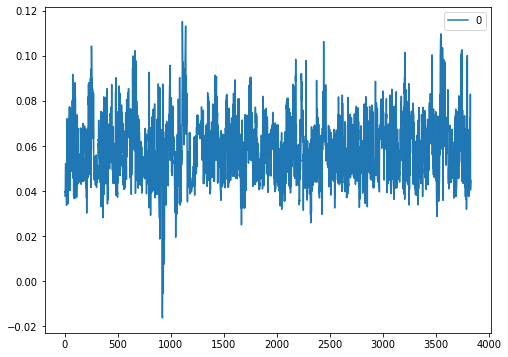

In [53]:
pd.DataFrame(x_pred).plot()

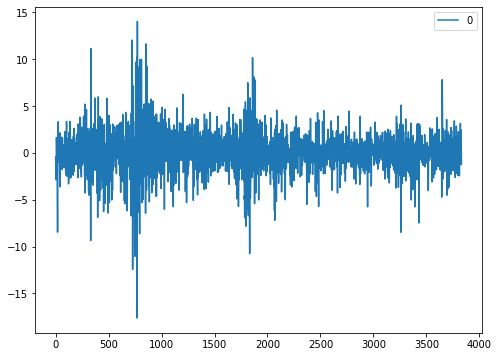

In [54]:
pd.DataFrame(y_train).plot()

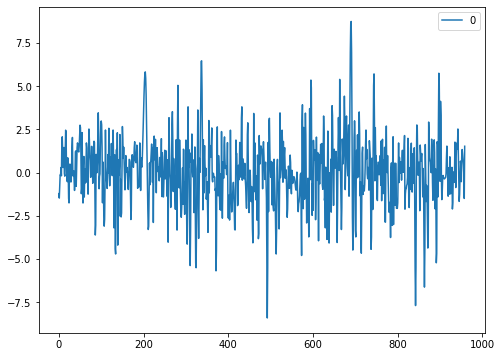

In [55]:
pd.DataFrame(y_test).plot()

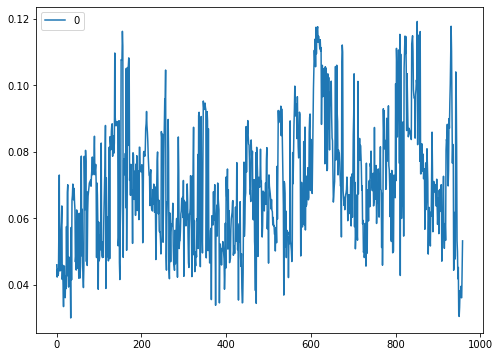

In [56]:
pd.DataFrame(y_pred).plot()

In [ ]:
#mse = h.history['mse']
#val_mse = h.history['val_mse']
loss = h.history['loss']
#val_loss = h.history['val_loss']

epochs = range(1, len(loss) + 1)

#plt.plot(epochs, mse, 'bo', label = 'Training mse')
#plt.plot(epohcs, val_mse, 'b', label = 'Validation mse')
#plt.title('mse')
#plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
#plt.plot(epohcs, val_mse, 'b', label = 'Validation loss')
plt.title('loss')
plt.legend()

plt.show()

In [ ]:
a_axis = np.arange(0, len(y_train))
b_axis = np.arange(len(y_train), len(y_train) + len(y_pred))

plt.figure(figsize=(10,6))
plt.plot(a_axis, y_train.reshape(4040,), '-')
plt.plot(b_axis, y_pred.reshape(1011,), '-', color='red', label='Predicted')
plt.plot(b_axis, y_test.reshape(1011,), '-', color='green', alpha=0.2, label='Actual')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Prices vs Predicted price Index: $Y_i$ vs $\\hat{Y}_i$')

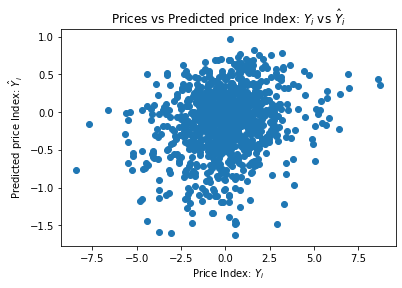

In [279]:
y_pred = model.predict(X_test_t, batch_size=32)
plt.scatter(y_test, y_pred)
plt.xlabel("Price Index: $Y_i$")
plt.ylabel("Predicted price Index: $\hat{Y}_i$")
plt.title("Prices vs Predicted price Index: $Y_i$ vs $\hat{Y}_i$")